In [1]:
# %pip install scikit-learn
# %pip install pandas
# %pip install matplotlib

In [2]:
import numpy as np
import pandas as pd

In [3]:
#read data
loan_data_bkup = pd.read_csv("/Users/berling/credit_risk_modeling_python/3.1 loan_data_2007_2014.csv",
                             low_memory = False)
loan_data_bkup.drop(columns = "Unnamed: 0", inplace = True)

In [4]:
#Backup
loan_data = loan_data_bkup.copy()

In [5]:
#display all columns
pd.options.display.max_columns = None

In [6]:
#remove duplicates
loan_data = loan_data.drop_duplicates()

In [7]:
#features
loan_data.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           466285 non-null  int64  
 1   member_id                    466285 non-null  int64  
 2   loan_amnt                    466285 non-null  int64  
 3   funded_amnt                  466285 non-null  int64  
 4   funded_amnt_inv              466285 non-null  float64
 5   term                         466285 non-null  object 
 6   int_rate                     466285 non-null  float64
 7   installment                  466285 non-null  float64
 8   grade                        466285 non-null  object 
 9   sub_grade                    466285 non-null  object 
 10  emp_title                    438697 non-null  object 
 11  emp_length                   445277 non-null  object 
 12  home_ownership               466285 non-null  object 
 13 

In [8]:
from datetime import datetime, timedelta

In [9]:
#tenure of employment
loan_data['emp_length'].value_counts()

emp_length
10+ years    150049
2 years       41373
3 years       36596
< 1 year      36265
5 years       30774
1 year        29622
4 years       28023
7 years       26180
6 years       26112
8 years       22395
9 years       17888
Name: count, dtype: int64

In [10]:
loan_data['emp_length_int'] = loan_data['emp_length'].str.replace('< 1 year','0', regex = False)
loan_data['emp_length_int'] = pd.to_numeric(loan_data['emp_length_int'].str.replace(r'\D','',regex = True))

In [11]:
loan_data['emp_length_int'].value_counts()

emp_length_int
10.0    150049
2.0      41373
3.0      36596
0.0      36265
5.0      30774
1.0      29622
4.0      28023
7.0      26180
6.0      26112
8.0      22395
9.0      17888
Name: count, dtype: int64

In [12]:
#term of loan payment
loan_data['term'].value_counts()

term
36 months    337953
60 months    128332
Name: count, dtype: int64

In [13]:
loan_data['term_int'] = pd.to_numeric(loan_data['term'].str.replace(r'\D','', regex = True))

In [14]:
loan_data['term_int'].value_counts()

term_int
36    337953
60    128332
Name: count, dtype: int64

In [15]:
#earliest credit line
loan_data['earliest_cr_line'].sample(10)

229841    Mar-01
140508    Jan-76
440525    Oct-80
393582    Jul-02
103849    Jan-04
412765    Apr-04
430222    Jul-01
105537    Jun-04
427800    Aug-97
419303    Oct-90
Name: earliest_cr_line, dtype: object

In [16]:
#didnt work for years before 1970
loan_data['earliest_cr_line_date'] = pd.to_datetime(loan_data['earliest_cr_line'], format = '%b-%y')

In [17]:
loan_data['earliest_cr_line_date'] = loan_data['earliest_cr_line'].apply(lambda x : (datetime.strptime(x, "%b-%y")\
    .replace(year = 1900 + int(x[-2:]) if int(x[-2:]) > 24 else 2000 + int(x[-2:])) ) if pd.notnull(x) else pd.NaT)

In [18]:
loan_data['mths_since_earliest_cr_line'] = round((pd.to_datetime('2017-12-01') - loan_data['earliest_cr_line_date'])/np.timedelta64(30,'D'))

In [19]:
loan_data['mths_since_earliest_cr_line'].describe()

count    466256.000000
mean        246.032075
std          88.194594
min          74.000000
25%         187.000000
50%         229.000000
75%         289.000000
max         900.000000
Name: mths_since_earliest_cr_line, dtype: float64

In [20]:
#date of issue
loan_data['issue_d'].sample(10)

330961    Aug-14
456674    Jan-14
277716    Oct-14
100341    Aug-13
238930    Dec-14
261483    Nov-14
446443    Feb-14
227053    Feb-12
466170    Jan-14
2735      Dec-11
Name: issue_d, dtype: object

In [21]:
loan_data['issue_d_date'] = loan_data['issue_d'].apply(lambda x: (datetime.strptime(x,"%b-%y").replace(year = 1900 + int(x[-2:]) if int(x[-2:]) > 24 else 2000 + int(x[-2:])))\
    if pd.notnull(x) else pd.NaT)

In [22]:
loan_data['issue_d_date'].min(), loan_data['issue_d_date'].max()

(Timestamp('2007-06-01 00:00:00'), Timestamp('2014-12-01 00:00:00'))

In [23]:
loan_data['mths_since_issue_d'] = round((pd.to_datetime('2017-12-01') - loan_data['issue_d_date'])/np.timedelta64(30,'D'))

In [24]:
loan_data.select_dtypes(include = ['object']).columns

Index(['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'next_pymnt_d', 'last_credit_pull_d', 'application_type'],
      dtype='object')

In [25]:
discrete_columns = ["grade","sub_grade","home_ownership","verification_status","loan_status","purpose","addr_state","initial_list_status"]

In [26]:
def one_hot_encode(df,col):
    return pd.get_dummies(df[col],prefix = col, prefix_sep = '_')

In [27]:
encoded_lst = []
for col in discrete_columns:
    encoded_lst += [one_hot_encode(loan_data, col)]
encoded_df = pd.concat(encoded_lst,axis = 1)

In [28]:
loan_data = pd.concat([loan_data, encoded_df], axis = 1)

In [29]:
loan_data['annual_inc'] = loan_data['annual_inc'].fillna(loan_data['annual_inc'].mean())

In [30]:
missing_val_columns = ['mths_since_earliest_cr_line',
'acc_now_delinq',
'total_acc',
'pub_rec',
'open_acc',
'inq_last_6mths',
'delinq_2yrs',
'emp_length_int']

In [31]:
for col in missing_val_columns:
    loan_data[col] = loan_data[col].fillna(0)

In [32]:
#loan status distribution
loan_data['loan_status'].value_counts()/loan_data['loan_status'].count() * 100

loan_status
Current                                                48.087757
Fully Paid                                             39.619332
Charged Off                                             9.109236
Late (31-120 days)                                      1.479782
In Grace Period                                         0.674695
Does not meet the credit policy. Status:Fully Paid      0.426349
Late (16-30 days)                                       0.261214
Default                                                 0.178432
Does not meet the credit policy. Status:Charged Off     0.163205
Name: count, dtype: float64

In [33]:
loan_data.to_csv("loan_data_preprocessed_2007_2014.csv")

In [34]:
loan_data['good_bad'] = np.where(loan_data['loan_status'].isin(['Charged Off',
                                                                'Late (31-120 days)',
                                                                'Default',
                                                                'Does not meet the credit policy. Status:Charged Off'
                                                                ]),0,1)

In [35]:
loan_data['good_bad'].value_counts()

good_bad
1    415317
0     50968
Name: count, dtype: int64

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
loan_data_inputs_train, loan_data_inputs_test, loan_data_targets_train, loan_data_targets_test = train_test_split(loan_data.drop(columns = "good_bad"), 
                                                                                                                  loan_data['good_bad'],test_size = 0.2,
                                                                                                                  random_state = 42,)

In [38]:
#Information Value Calculation
def calculate_woe_iv(cat_series, outcome_series):
    
    df = pd.concat([cat_series, outcome_series], axis = 1)
    
    #count the distribution of outcome in each category
    prop_series = df.groupby([cat_series.name,outcome_series.name])[outcome_series.name].count()
    prop_series.name = 'outcome_count_i'
    df = prop_series.reset_index()
    
    #count the net outcome distribution
    df['outcome_count'] = df[outcome_series.name].map(df.groupby([outcome_series.name])['outcome_count_i'].sum())
    df['outcome_prop_i'] = df['outcome_count_i']/df['outcome_count']
    
    df_1 = df.pivot(index = [cat_series.name], columns = [outcome_series.name])['outcome_prop_i']
    df_1 = df_1.add_prefix('prop_')
    df_2 = df.pivot(index = [cat_series.name], columns = [outcome_series.name])['outcome_count_i']
    df_2 = df_2.add_prefix('count_')
    
    df = pd.concat([df_1, df_2], axis = 1).reset_index()
    
    df['WoE_i'] = np.log(df['prop_1']/df['prop_0'])
    df['IV_i'] = (df['prop_1'] - df['prop_0']) * df['WoE_i']
    df['IV'] = df['IV_i'].sum()
    
    return df.sort_values('WoE_i').reset_index(drop = True)

In [39]:
import matplotlib.pyplot as plt

In [40]:
#plot WoE
def plot_woe(df, cat_col):
    df_plot = df.copy()#.sort_values('WoE_i',).reset_index(drop = True)
    x = np.array(df_plot[cat_col].astype(str))
    y = df_plot['WoE_i']
    
    plt.figure(figsize = (18,6))
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel(cat_col)
    plt.ylabel('WoE')
    plt.title(f"Weight of Evidence by {cat_col}")
    
    plt.xticks(rotation = 90)
    

In [41]:
# df_inputs_prepr = loan_data_inputs_train.copy()
# df_targets_prepr = loan_data_targets_train.copy()

In [42]:
df_inputs_prepr = loan_data_inputs_test.copy()
df_targets_prepr = loan_data_targets_test.copy()

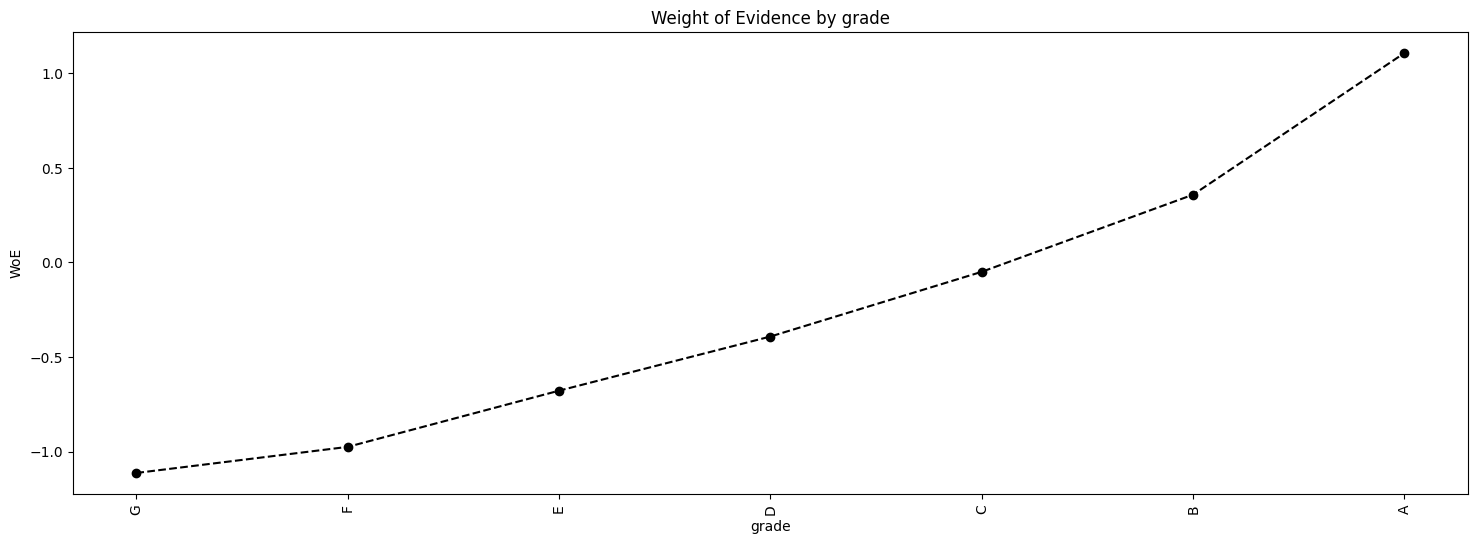

In [43]:
df_temp = calculate_woe_iv(loan_data_inputs_train["grade"], loan_data_targets_train)
plot_woe(df_temp,'grade')

In [44]:
df_temp

good_bad,grade,prop_0,prop_1,count_0,count_1,WoE_i,IV_i,IV
0,G,0.017706,0.005815,722,1932,-1.113459,0.013240,0.288636
1,F,0.063417,0.023910,2586,7944,-0.975440,0.038537,0.288636
2,E,0.136642,0.069345,5572,23040,-0.678267,0.045645,0.288636
3,D,0.231792,0.156647,9452,52046,-0.391843,0.029445,0.288636
4,C,0.280813,0.267251,11451,88794,-0.049503,0.000671,0.288636
5,B,0.212541,0.304178,8667,101063,0.358476,0.032850,0.288636
6,A,0.057090,0.172855,2328,57431,1.107830,0.128248,0.288636


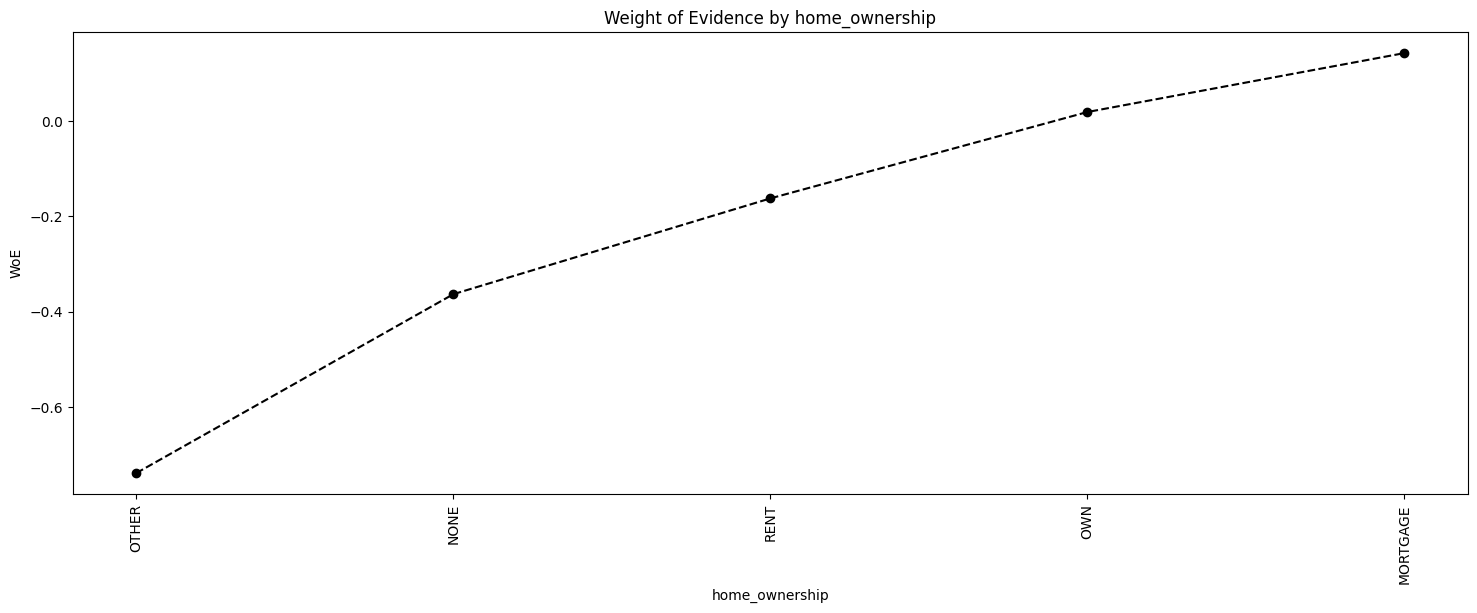

In [45]:
df_temp = calculate_woe_iv(loan_data_inputs_train["home_ownership"], loan_data_targets_train)
plot_woe(df_temp,'home_ownership')

In [46]:
df_temp

good_bad,home_ownership,prop_0,prop_1,count_0,count_1,WoE_i,IV_i,IV
0,OTHER,0.000687,0.000328,28.0,109.0,-0.738602,0.000265,0.021389
1,NONE,0.000147,0.000102,6.0,34.0,-0.363144,0.000016,0.021389
2,RENT,0.465815,0.396099,18995.0,131604.0,-0.162123,0.011303,0.021389
3,OWN,0.087743,0.089442,3578.0,29717.0,0.019170,0.000033,0.021389
4,MORTGAGE,0.445608,0.514026,18171.0,170785.0,0.142834,0.009772,0.021389
5,ANY,NaN,0.000003,NaN,1.0,NaN,NaN,0.021389


# combining the categories none, other with rent since the prior doesn't have enough data points

## 1

## 2

In [47]:
df_inputs_prepr['home_ownership_RENT_OTHER_NONE_ANY'] = sum([df_inputs_prepr['home_ownership_RENT'],
                                                            df_inputs_prepr['home_ownership_OTHER'],
                                                            df_inputs_prepr['home_ownership_NONE'],
                                                            df_inputs_prepr['home_ownership_ANY']])


In [48]:
df_inputs_prepr['addr_state'].value_counts()

addr_state
CA    14251
NY     8031
TX     7281
FL     6426
IL     3779
NJ     3676
PA     3334
OH     3102
GA     3015
VA     2856
NC     2478
MI     2358
MA     2214
MD     2203
WA     2145
AZ     2067
CO     1916
MN     1632
MO     1491
CT     1429
IN     1315
NV     1298
AL     1182
WI     1171
TN     1139
OR     1135
SC     1135
LA     1130
KY      851
OK      833
KS      830
AR      728
UT      672
NM      513
WV      486
HI      486
RI      403
NH      402
DC      297
MT      293
AK      248
MS      246
WY      209
DE      208
SD      179
VT      178
ID        2
ME        2
IA        1
NE        1
Name: count, dtype: int64

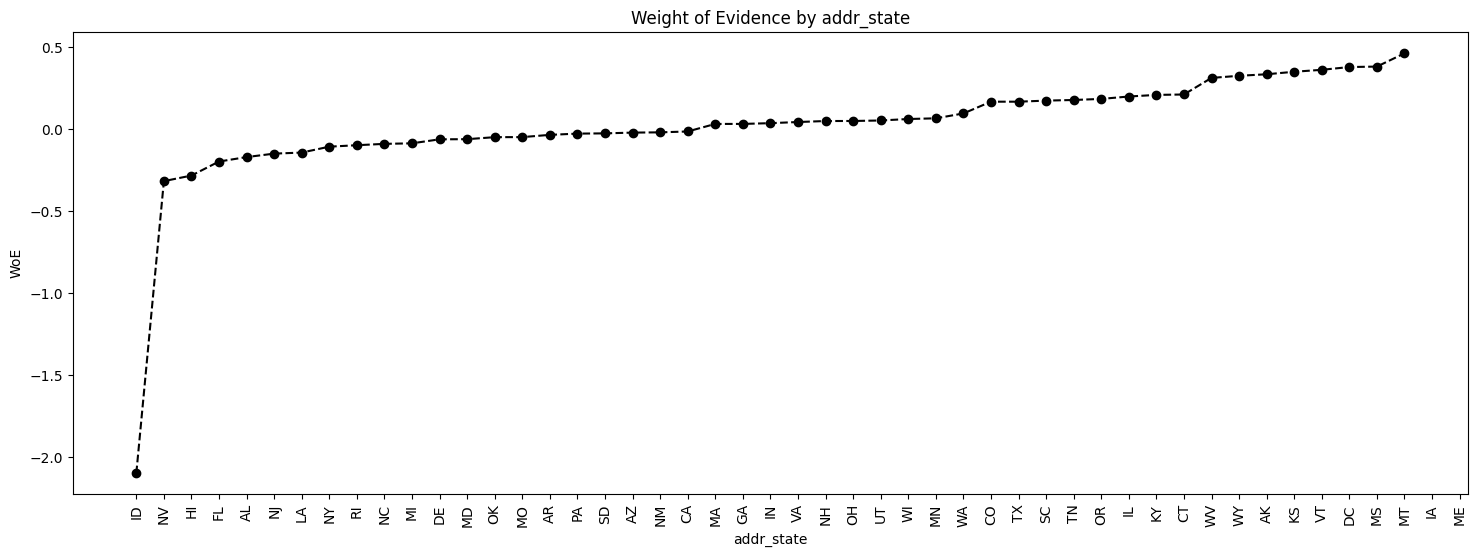

In [49]:
df_temp = calculate_woe_iv(df_inputs_prepr["addr_state"], df_targets_prepr)
plot_woe(df_temp,'addr_state')

## 3

In [50]:
if 'addr_state_ND' in list(df_inputs_prepr):
    pass
else:
    df_inputs_prepr['addr_state_ND'] = 0

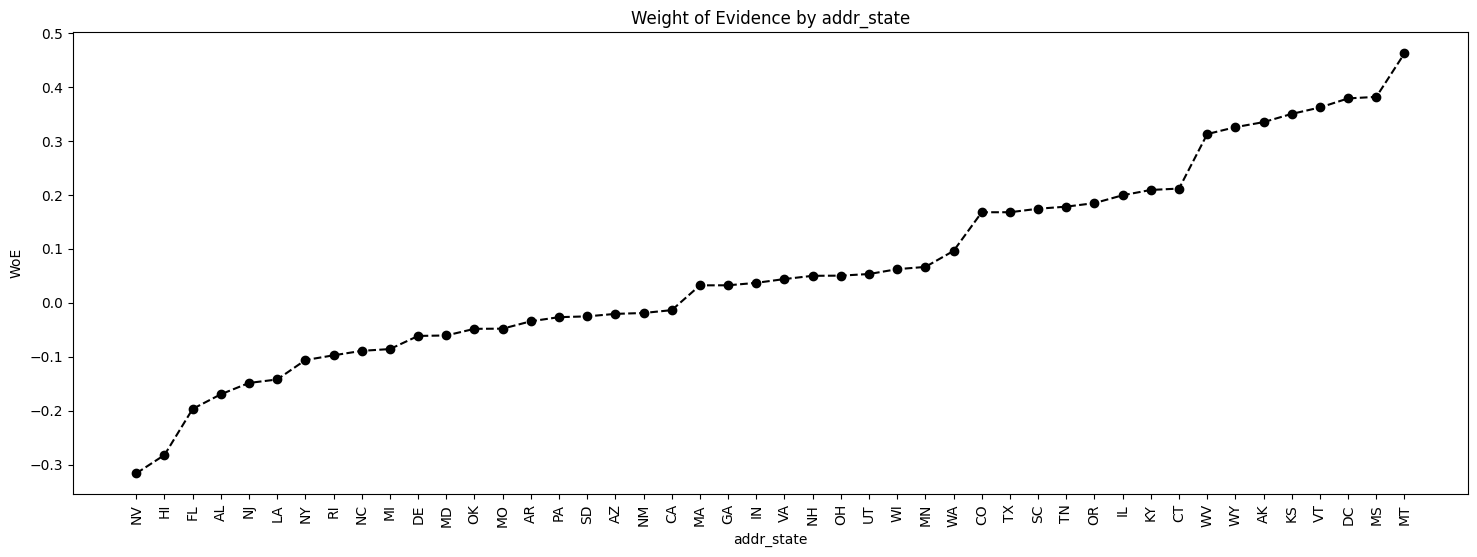

In [51]:
plot_woe(df_temp.loc[~df_temp['addr_state'].isin(['NE','IA','ID','ME'])],'addr_state')

# Combining NE, IA, NV, FL, AL plus ND (no data needs to be put in high risk category)
 

## 4

In [52]:
df_inputs_prepr['addr_state_ND_NE_IA_NV_FL_HI_AL'] = sum([df_inputs_prepr['addr_state_ND'],
                                                          df_inputs_prepr['addr_state_NE'],
                                                          df_inputs_prepr['addr_state_IA'],
                                                          df_inputs_prepr['addr_state_NV'],
                                                          df_inputs_prepr['addr_state_FL'],
                                                          df_inputs_prepr['addr_state_HI'],
                                                          df_inputs_prepr['addr_state_AL'],])

# Combining WV, NH, WY, DC plus ME, ID 

## 5

In [53]:
df_inputs_prepr['addr_state_WV_NH_WY_DC_ME_ID'] = sum([df_inputs_prepr['addr_state_WV'], df_inputs_prepr['addr_state_NH'],
                                              df_inputs_prepr['addr_state_WY'], df_inputs_prepr['addr_state_DC'],
                                              df_inputs_prepr['addr_state_ME'], df_inputs_prepr['addr_state_ID']])

In [54]:
df_inputs_prepr['addr_state_NM_VA'] = sum([df_inputs_prepr['addr_state_NM'], df_inputs_prepr['addr_state_VA']])

df_inputs_prepr['addr_state_OK_TN_MO_LA_MD_NC'] = sum([df_inputs_prepr['addr_state_OK'], df_inputs_prepr['addr_state_TN'],
                                              df_inputs_prepr['addr_state_MO'], df_inputs_prepr['addr_state_LA'],
                                              df_inputs_prepr['addr_state_MD'], df_inputs_prepr['addr_state_NC']])

df_inputs_prepr['addr_state_UT_KY_AZ_NJ'] = sum([df_inputs_prepr['addr_state_UT'], df_inputs_prepr['addr_state_KY'],
                                              df_inputs_prepr['addr_state_AZ'], df_inputs_prepr['addr_state_NJ']])

df_inputs_prepr['addr_state_AR_MI_PA_OH_MN'] = sum([df_inputs_prepr['addr_state_AR'], df_inputs_prepr['addr_state_MI'],
                                              df_inputs_prepr['addr_state_PA'], df_inputs_prepr['addr_state_OH'],
                                              df_inputs_prepr['addr_state_MN']])

df_inputs_prepr['addr_state_RI_MA_DE_SD_IN'] = sum([df_inputs_prepr['addr_state_RI'], df_inputs_prepr['addr_state_MA'],
                                              df_inputs_prepr['addr_state_DE'], df_inputs_prepr['addr_state_SD'],
                                              df_inputs_prepr['addr_state_IN']])

df_inputs_prepr['addr_state_GA_WA_OR'] = sum([df_inputs_prepr['addr_state_GA'], df_inputs_prepr['addr_state_WA'],
                                              df_inputs_prepr['addr_state_OR']])

df_inputs_prepr['addr_state_WI_MT'] = sum([df_inputs_prepr['addr_state_WI'], df_inputs_prepr['addr_state_MT']])

df_inputs_prepr['addr_state_IL_CT'] = sum([df_inputs_prepr['addr_state_IL'], df_inputs_prepr['addr_state_CT']])

df_inputs_prepr['addr_state_KS_SC_CO_VT_AK_MS'] = sum([df_inputs_prepr['addr_state_KS'], df_inputs_prepr['addr_state_SC'],
                                              df_inputs_prepr['addr_state_CO'], df_inputs_prepr['addr_state_VT'],
                                              df_inputs_prepr['addr_state_AK'], df_inputs_prepr['addr_state_MS']])

# NewYork and California has significant amount of data hence needs to be kept as separate variables

In [55]:
df_inputs_prepr['verification_status'].value_counts()

verification_status
Verified           33641
Source Verified    29963
Not Verified       29653
Name: count, dtype: int64

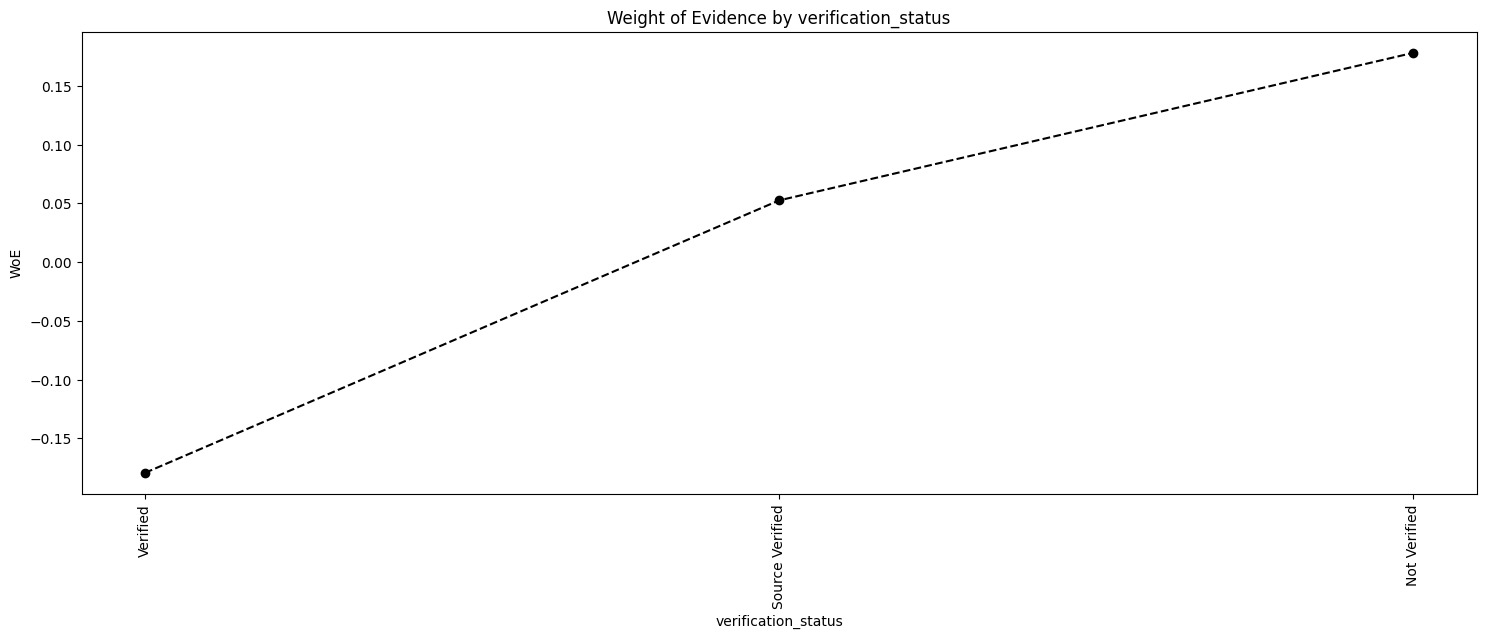

In [56]:
df_temp = calculate_woe_iv(df_inputs_prepr['verification_status'], df_targets_prepr)
plot_woe(df_temp,'verification_status')

In [57]:
df_temp

good_bad,verification_status,prop_0,prop_1,count_0,count_1,WoE_i,IV_i,IV
0,Verified,0.422473,0.353161,4305,29336,-0.179202,0.012421,0.022684
1,Source Verified,0.306575,0.323101,3124,26839,0.052501,0.000868,0.022684
2,Not Verified,0.270952,0.323739,2761,26892,0.177995,0.009396,0.022684


In [58]:
df_inputs_prepr['purpose'].value_counts()

purpose
debt_consolidation    55012
credit_card           20576
home_improvement       5299
other                  4806
major_purchase         1991
small_business         1431
car                    1072
medical                 918
moving                  602
vacation                496
wedding                 456
house                   439
educational              89
renewable_energy         70
Name: count, dtype: int64

In [59]:
'educational', 'small_business', 'wedding', 'renewable_energy', 'moving', 'house'

('educational',
 'small_business',
 'wedding',
 'renewable_energy',
 'moving',
 'house')

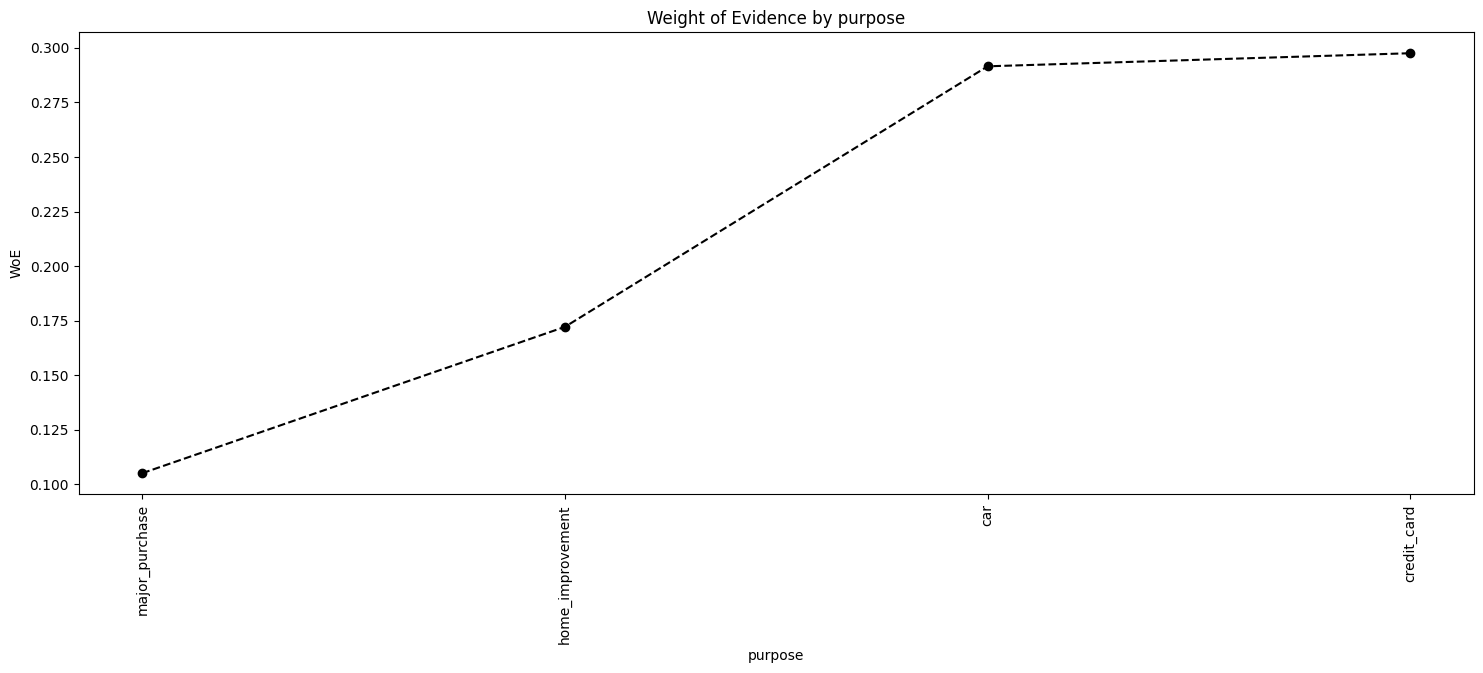

In [60]:
df_temp = calculate_woe_iv(df_inputs_prepr['purpose'], df_targets_prepr)
plot_woe(df_temp[~df_temp['purpose'].isin(['small_business','educational','moving','house',
                                           'other', 'renewable_energy','medical','wedding',
                                           'vacation','debt_consolidation'])],'purpose')

In [61]:
df_temp

good_bad,purpose,prop_0,prop_1,count_0,count_1,WoE_i,IV_i,IV
0,educational,0.002159,0.000807,22,67,-0.984590,0.001332,0.045124
1,renewable_energy,0.001570,0.000650,16,54,-0.881845,0.000811,0.045124
2,small_business,0.031305,0.013387,319,1112,-0.849516,0.015222,0.045124
3,medical,0.012856,0.009474,131,787,-0.305210,0.001032,0.045124
4,house,0.006084,0.004539,62,377,-0.293130,0.000453,0.045124
5,other,0.065554,0.049815,668,4138,-0.274561,0.004321,0.045124
6,wedding,0.006084,0.004743,62,394,-0.249024,0.000334,0.045124
7,moving,0.007164,0.006368,73,529,-0.117712,0.000094,0.045124
8,vacation,0.005790,0.005261,59,437,-0.095845,0.000051,0.045124
9,debt_consolidation,0.615898,0.586707,6276,48736,-0.048556,0.001417,0.045124


# combining small_business, educational

# combining moving, house

# combining other, renewable energy, medical

# combining wedding, vacation

# keeping debt_consolidation separately because of significant data

# keeping home improvement separately because of significant data

# combining major purchase, car

# keeping credit card separately because of significant data

## 6

In [62]:
df_inputs_prepr['purpose_educ__sm_b__wedd__ren_en__mov__house'] = sum([df_inputs_prepr['purpose_educational'], df_inputs_prepr['purpose_small_business'],
                                                                 df_inputs_prepr['purpose_wedding'], df_inputs_prepr['purpose_renewable_energy'],
                                                                 df_inputs_prepr['purpose_moving'], df_inputs_prepr['purpose_house']])
df_inputs_prepr['purpose_oth__med__vacation'] = sum([df_inputs_prepr['purpose_other'], df_inputs_prepr['purpose_medical'],
                                             df_inputs_prepr['purpose_vacation']])
df_inputs_prepr['purpose_major_purch__car__home_impr'] = sum([df_inputs_prepr['purpose_major_purchase'], df_inputs_prepr['purpose_car'],
                                                        df_inputs_prepr['purpose_home_improvement']])

In [63]:
df_inputs_prepr['initial_list_status'].value_counts()

initial_list_status
f    60491
w    32766
Name: count, dtype: int64

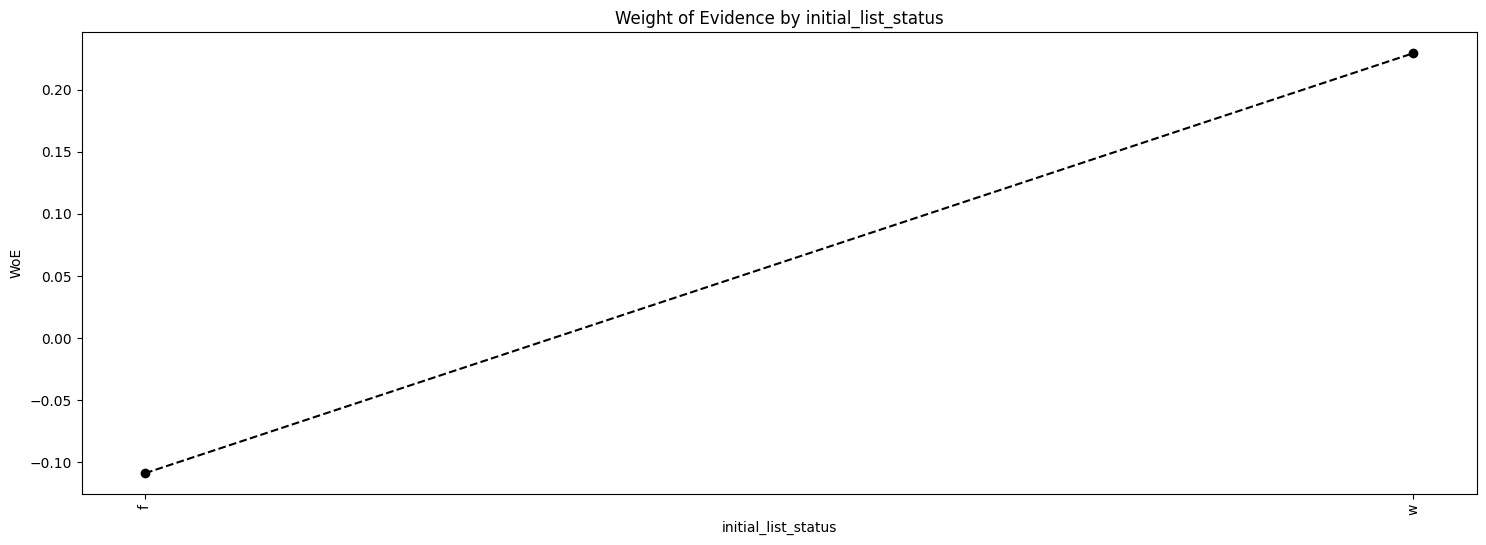

In [64]:
df_temp = calculate_woe_iv(df_inputs_prepr['initial_list_status'], df_targets_prepr)
plot_woe(df_temp,'initial_list_status')

# Preprocessing continuous variables

In [65]:
df_inputs_prepr['term_int'].value_counts()

term_int
36    67534
60    25723
Name: count, dtype: int64

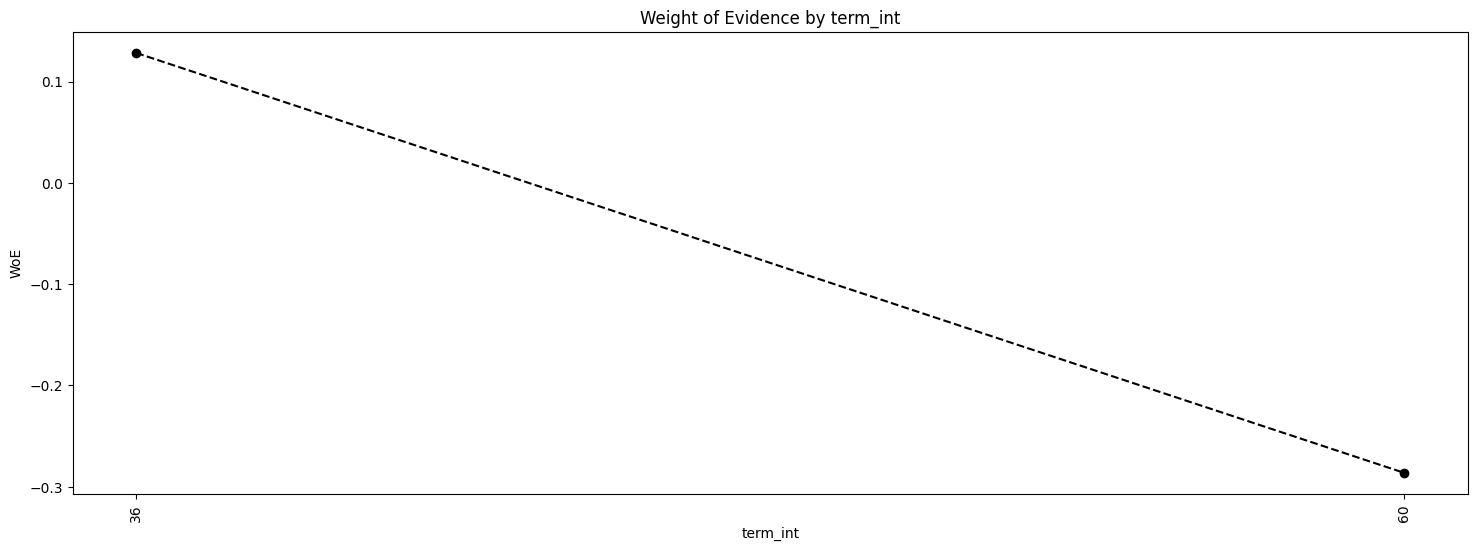

In [66]:
df_temp = calculate_woe_iv(df_inputs_prepr['term_int'], df_targets_prepr)
plot_woe(df_temp.sort_values('term_int', ascending = True).reset_index(drop = True),'term_int')

## 7

In [67]:
df_inputs_prepr['term_36'] = np.where(df_inputs_prepr['term_int'] == 36, 1,0)
df_inputs_prepr['term_60'] = np.where(df_inputs_prepr['term_int'] == 60, 1,0)

In [68]:
df_inputs_prepr['emp_length_int'].value_counts()

emp_length_int
10.0    29804
0.0     11553
2.0      8295
3.0      7391
5.0      6172
1.0      5968
4.0      5555
6.0      5225
7.0      5131
8.0      4542
9.0      3621
Name: count, dtype: int64

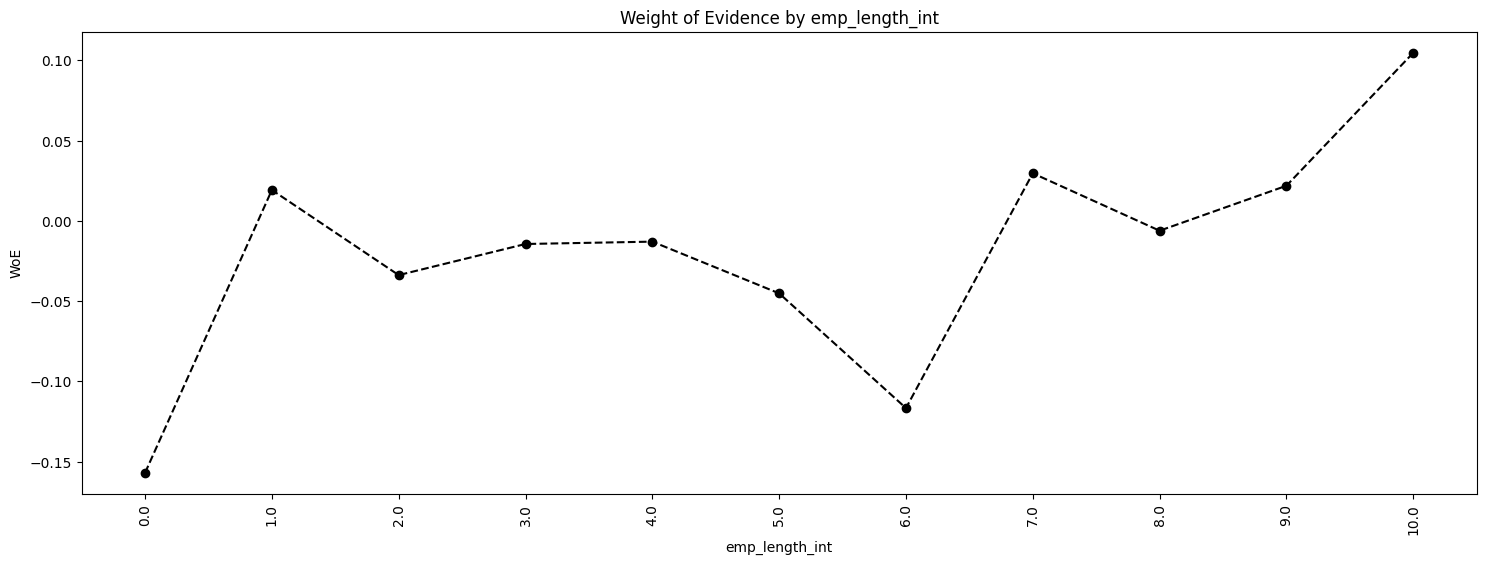

In [69]:
df_temp = calculate_woe_iv(df_inputs_prepr['emp_length_int'], df_targets_prepr)
plot_woe(df_temp.sort_values('emp_length_int', ascending = True).reset_index(drop = True),'emp_length_int')

## 8

In [70]:
# We create the following categories_ '0', '1', '2 - 4', '5 - 6', '7 - 9', '10'
# '0' will be the reference category
df_inputs_prepr['emp_length_0'] = np.where(df_inputs_prepr['emp_length_int'].isin([0]), 1, 0)
df_inputs_prepr['emp_length_1'] = np.where(df_inputs_prepr['emp_length_int'].isin([1]), 1, 0)
df_inputs_prepr['emp_length_2-4'] = np.where(df_inputs_prepr['emp_length_int'].isin(range(2, 5)), 1, 0)
df_inputs_prepr['emp_length_5-6'] = np.where(df_inputs_prepr['emp_length_int'].isin(range(5, 7)), 1, 0)
df_inputs_prepr['emp_length_7-9'] = np.where(df_inputs_prepr['emp_length_int'].isin(range(7, 10)), 1, 0)
df_inputs_prepr['emp_length_10'] = np.where(df_inputs_prepr['emp_length_int'].isin([10]), 1, 0)

In [71]:
df_inputs_prepr['mths_since_issue_d_factor'] = pd.cut(df_inputs_prepr['mths_since_issue_d'],50)

/var/folders/nz/9brs25k93qd9j8rw4y155hp00000gn/T/ipykernel_51791/421776125.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prop_series = df.groupby([cat_series.name,outcome_series.name])[outcome_series.name].count()


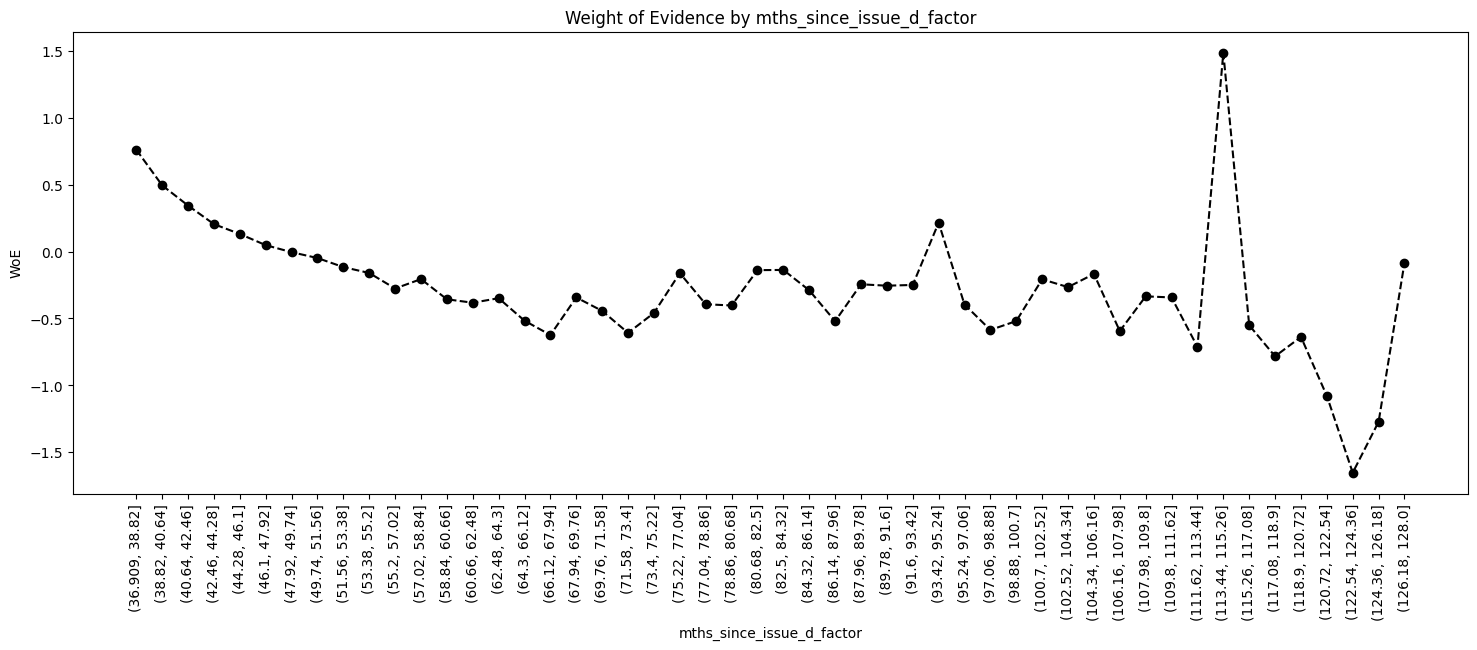

In [72]:
df_temp = calculate_woe_iv(df_inputs_prepr['mths_since_issue_d_factor'], df_targets_prepr)
plot_woe(df_temp.sort_values('mths_since_issue_d_factor', ascending = True).reset_index(drop = True),'mths_since_issue_d_factor')

## 9

In [73]:
# We create the following categories_
# < 38, 38 - 39, 40 - 41, 42 - 48, 49 - 52, 53 - 64, 65 - 84, > 84.
df_inputs_prepr['mths_since_issue_d_<38'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(38)), 1, 0)
df_inputs_prepr['mths_since_issue_d_38-39'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(38, 40)), 1, 0)
df_inputs_prepr['mths_since_issue_d_40-41'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(40, 42)), 1, 0)
df_inputs_prepr['mths_since_issue_d_42-48'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(42, 49)), 1, 0)
df_inputs_prepr['mths_since_issue_d_49-52'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(49, 53)), 1, 0)
df_inputs_prepr['mths_since_issue_d_53-64'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(53, 65)), 1, 0)
df_inputs_prepr['mths_since_issue_d_65-84'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(65, 85)), 1, 0)
df_inputs_prepr['mths_since_issue_d_>84'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(85, int(df_inputs_prepr['mths_since_issue_d'].max()))), 1, 0)

In [74]:
df_inputs_prepr['int_rate_factor'] = pd.cut(df_inputs_prepr['int_rate'], 50)

/var/folders/nz/9brs25k93qd9j8rw4y155hp00000gn/T/ipykernel_51791/421776125.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prop_series = df.groupby([cat_series.name,outcome_series.name])[outcome_series.name].count()


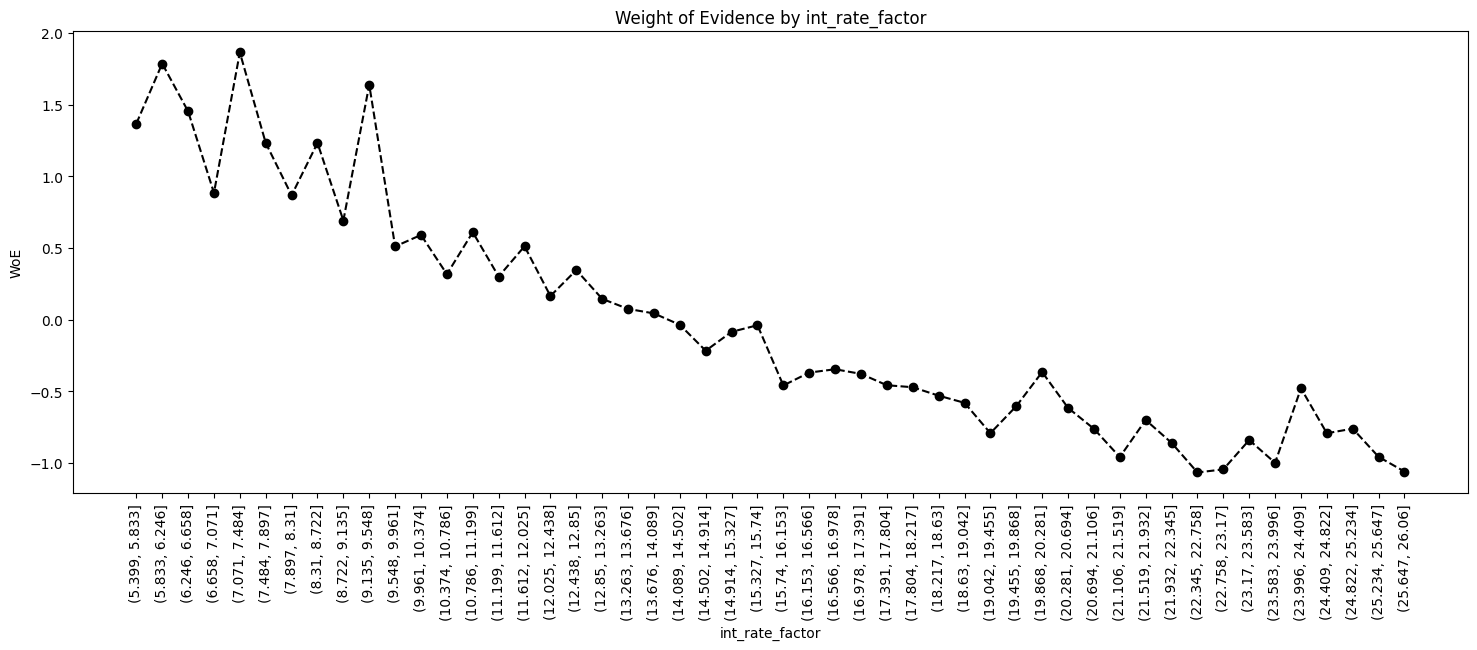

In [75]:
df_temp = calculate_woe_iv(df_inputs_prepr['int_rate_factor'], df_targets_prepr)
plot_woe(df_temp.sort_values('int_rate_factor', ascending = True).reset_index(drop = True),'int_rate_factor')

## 10

In [76]:
df_inputs_prepr['int_rate_<9.548'] = np.where((df_inputs_prepr['int_rate'] <= 9.548), 1, 0)
df_inputs_prepr['int_rate_9.548-12.025'] = np.where((df_inputs_prepr['int_rate'] > 9.548) & (df_inputs_prepr['int_rate'] <= 12.025), 1, 0)
df_inputs_prepr['int_rate_12.025-15.74'] = np.where((df_inputs_prepr['int_rate'] > 12.025) & (df_inputs_prepr['int_rate'] <= 15.74), 1, 0)
df_inputs_prepr['int_rate_15.74-20.281'] = np.where((df_inputs_prepr['int_rate'] > 15.74) & (df_inputs_prepr['int_rate'] <= 20.281), 1, 0)
df_inputs_prepr['int_rate_>20.281'] = np.where((df_inputs_prepr['int_rate'] > 20.281), 1, 0)

In [77]:
df_inputs_prepr['funded_amnt_factor'] = pd.cut(df_inputs_prepr['funded_amnt'], 50)

/var/folders/nz/9brs25k93qd9j8rw4y155hp00000gn/T/ipykernel_51791/421776125.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prop_series = df.groupby([cat_series.name,outcome_series.name])[outcome_series.name].count()


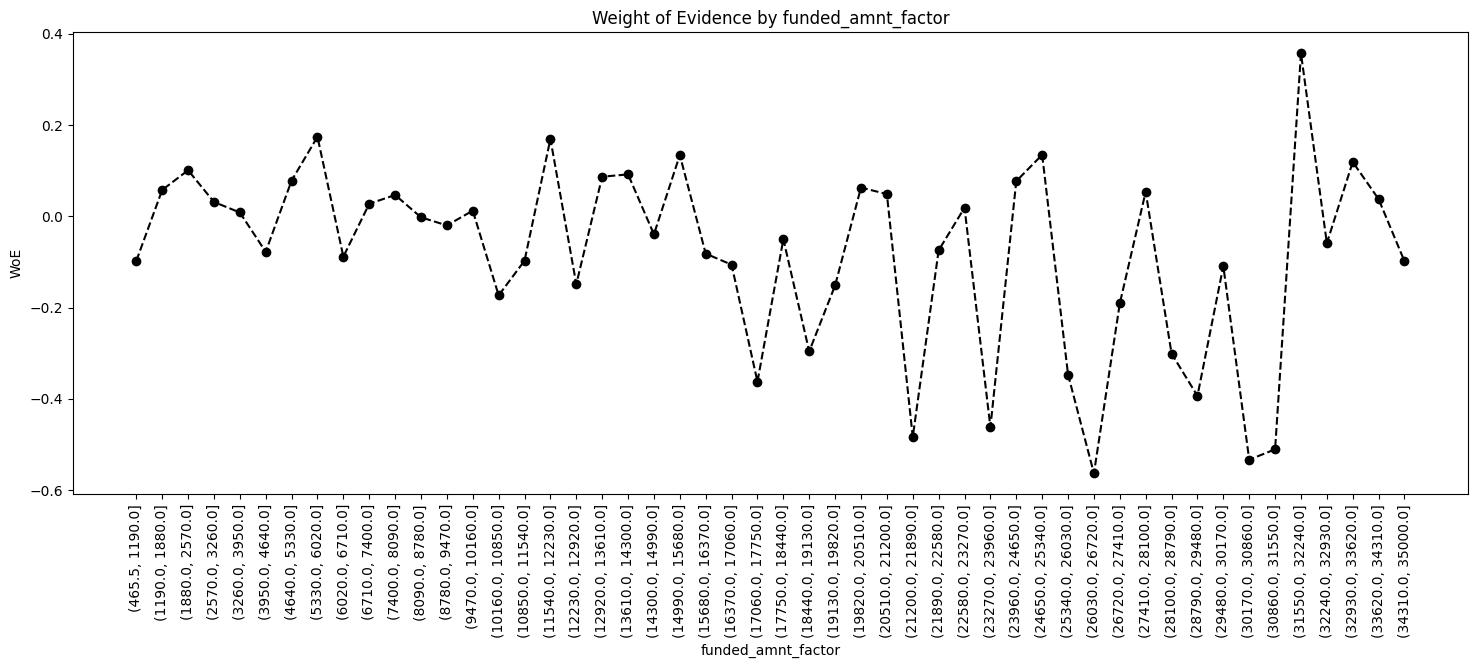

In [78]:
df_temp = calculate_woe_iv(df_inputs_prepr['funded_amnt_factor'], df_targets_prepr)
plot_woe(df_temp.sort_values('funded_amnt_factor', ascending = True).reset_index(drop = True),'funded_amnt_factor')

In [79]:
# ‘mths_since_earliest_cr_line’;
# ‘installment’;
# ‘delinq_2yrs’;
# ‘inq_last_6mths’;
# ‘open_acc’;
# ‘pub_rec’;
# ‘total_acc’;
# ‘acc_now_delinq’.

In [80]:
df_inputs_prepr['mths_since_earliest_cr_line'].unique()

array([191., 175., 192., 114., 379., 210., 337., 270., 389., 273., 333.,
       240., 297., 246., 231., 291., 234., 209., 267., 169., 242., 136.,
       447., 198., 129., 290., 195., 526., 172., 149., 152., 256., 205.,
       200., 193., 304., 236., 223., 422., 228., 220., 203., 212., 601.,
       197., 266., 158., 230., 397., 143., 186., 306., 271., 317., 367.,
       219., 444., 253., 277., 185., 224., 190., 575., 249., 208., 352.,
       217., 303., 179., 403., 392., 257., 247., 404., 155., 473., 201.,
       232., 244., 183., 395., 184., 171., 265., 384., 329., 406., 235.,
       493., 125., 355., 557., 141., 248., 259., 128., 222., 178., 117.,
       419., 176., 213., 278., 359., 258., 332., 326., 328., 204., 174.,
       284., 449., 334., 298., 261., 226., 262., 263., 160., 353., 164.,
       170., 307., 318., 302., 325.,  92., 445., 177., 528., 255., 322.,
       146., 207., 250., 412., 121., 308., 283., 385., 233., 162., 309.,
        80., 199., 310., 338., 336., 260., 115., 34

In [81]:
df_inputs_prepr['mths_since_earliest_cr_line_factor'] = pd.cut(df_inputs_prepr['mths_since_earliest_cr_line'],50)

/var/folders/nz/9brs25k93qd9j8rw4y155hp00000gn/T/ipykernel_51791/421776125.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prop_series = df.groupby([cat_series.name,outcome_series.name])[outcome_series.name].count()


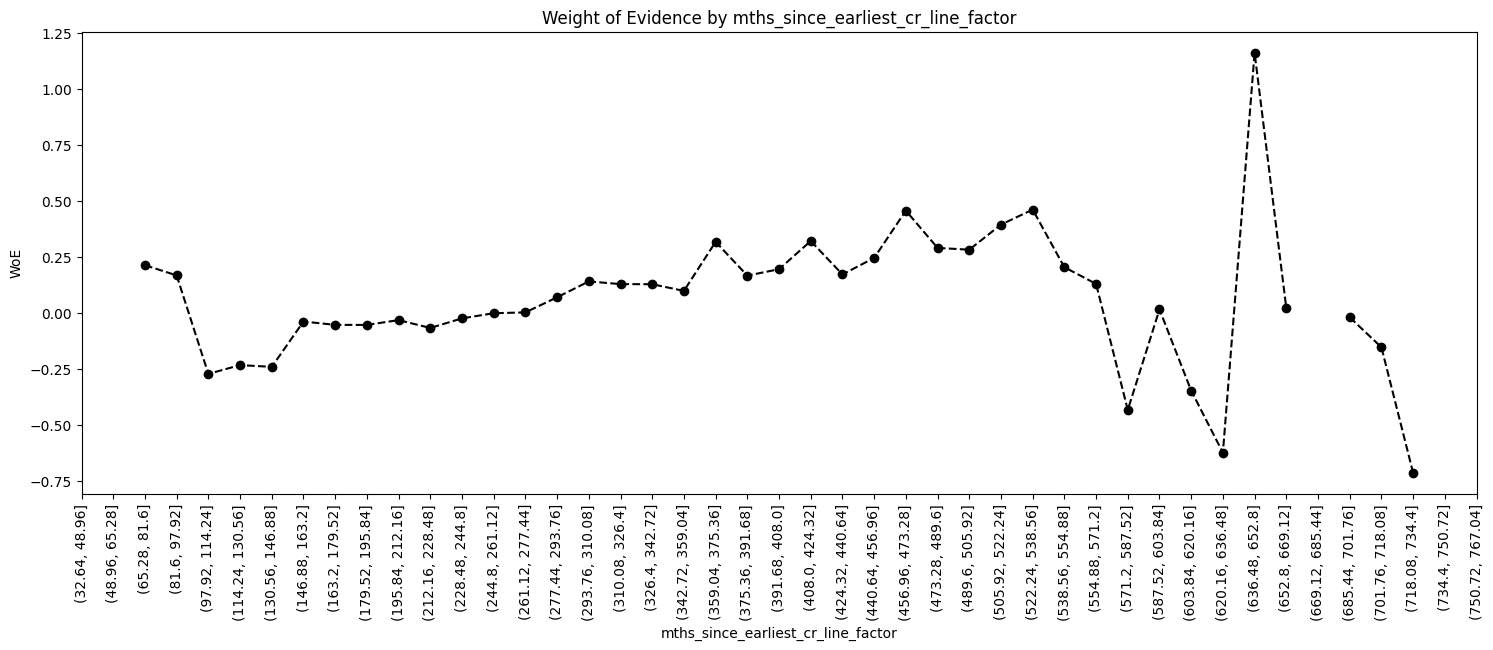

In [82]:
df_temp = calculate_woe_iv(df_inputs_prepr['mths_since_earliest_cr_line_factor'], df_targets_prepr)
plot_woe(df_temp.sort_values('mths_since_earliest_cr_line_factor', ascending = True).reset_index(drop = True),'mths_since_earliest_cr_line_factor')

## 11

In [83]:
# We create the following categories_
# < 140, # 141 - 164, # 165 - 247, # 248 - 270, # 271 - 352, # > 352
df_inputs_prepr['mths_since_earliest_cr_line_<140'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(range(140)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line_141-164'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(range(140, 165)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line_165-247'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(range(165, 248)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line_248-270'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(range(248, 271)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line_271-352'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(range(271, 353)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line_>352'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(range(353, int(df_inputs_prepr['mths_since_earliest_cr_line'].max()))), 1, 0)

In [84]:
df_inputs_prepr['delinq_2yrs'].unique()

array([ 0.,  1.,  2.,  3.,  4.,  6.,  5.,  7., 16.,  8., 18., 10.,  9.,
       13., 11., 14., 12., 19., 15.])

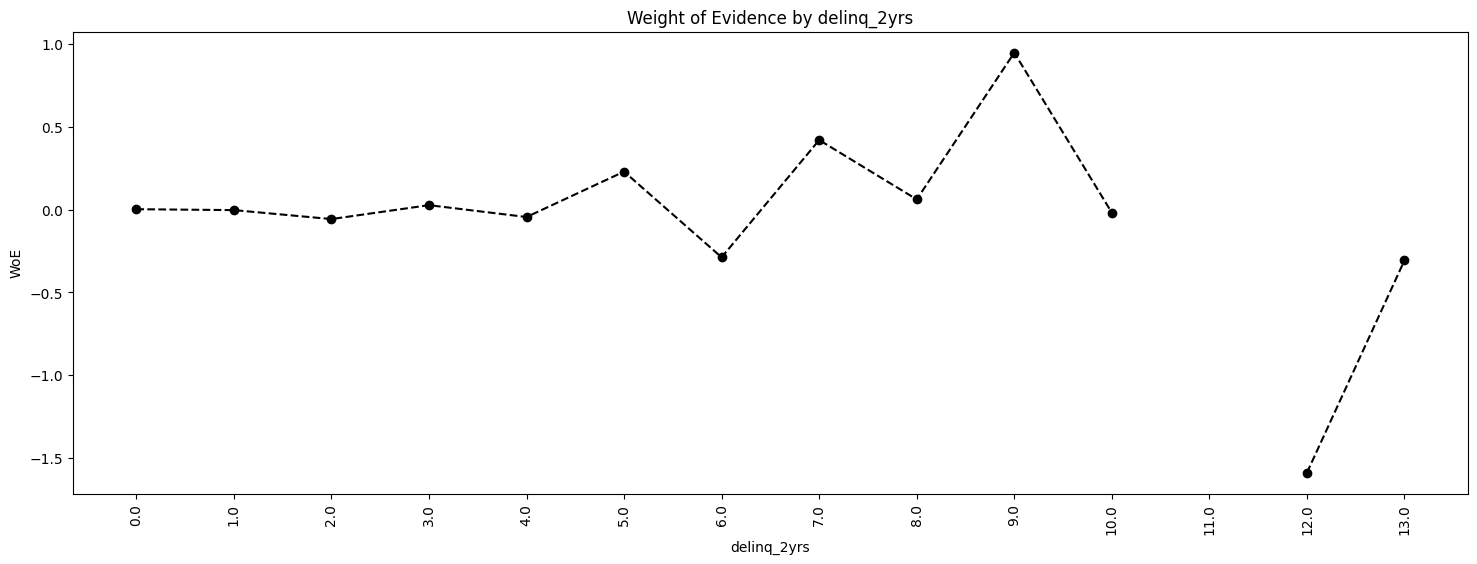

In [85]:
df_temp = calculate_woe_iv(df_inputs_prepr['delinq_2yrs'], df_targets_prepr)
plot_woe(df_temp.sort_values('delinq_2yrs', ascending = True).reset_index(drop = True),'delinq_2yrs')

## 12

In [86]:
df_inputs_prepr['delinq_2yrs_0'] = np.where((df_inputs_prepr['delinq_2yrs'] == 0), 1, 0)
df_inputs_prepr['delinq_2yrs_1-3'] = np.where((df_inputs_prepr['delinq_2yrs'] >= 1) & (df_inputs_prepr['delinq_2yrs'] <= 3), 1, 0)
df_inputs_prepr['delinq_2yrs_>=4'] = np.where((df_inputs_prepr['delinq_2yrs'] >= 4), 1, 0)

In [87]:
df_inputs_prepr['inq_last_6mths'].unique()

array([ 0.,  1.,  2.,  5.,  4.,  6.,  3.,  7.,  8., 11.,  9., 18., 19.,
       24., 10., 12., 13., 14.])

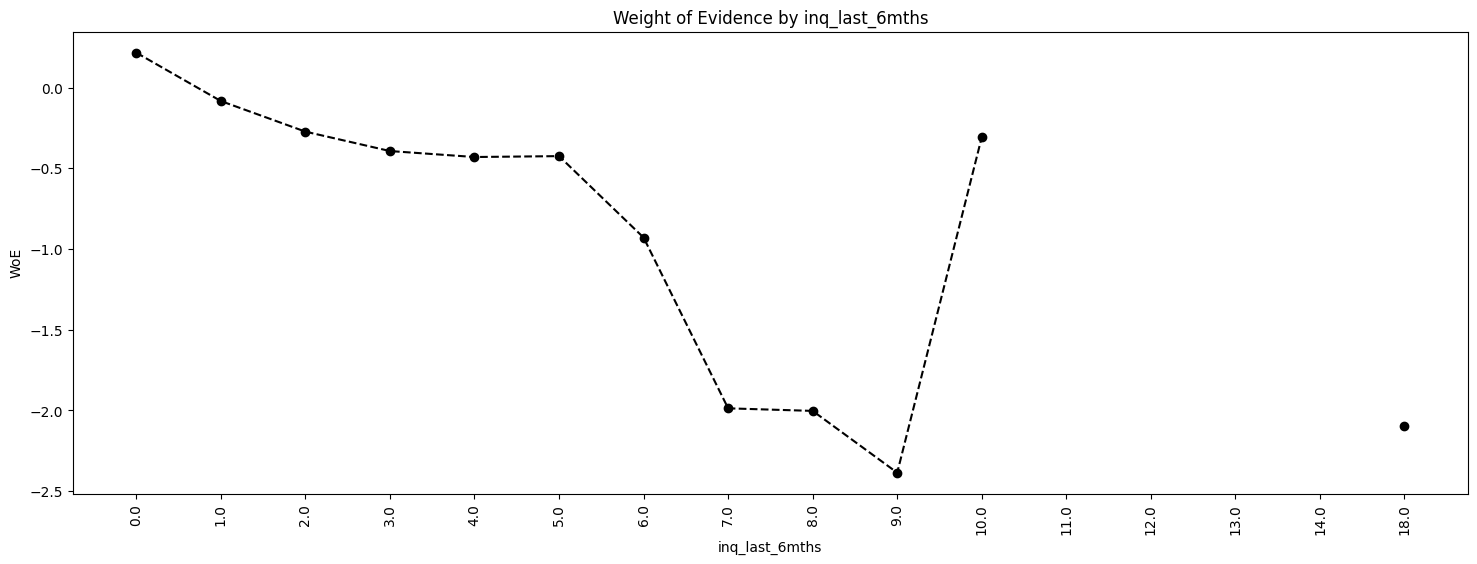

In [88]:
df_temp = calculate_woe_iv(df_inputs_prepr['inq_last_6mths'], df_targets_prepr)
plot_woe(df_temp.sort_values('inq_last_6mths', ascending = True).reset_index(drop = True),'inq_last_6mths')

## 13

In [89]:
# Categories_ 0, 1 - 2, 3 - 6, > 6
df_inputs_prepr['inq_last_6mths_0'] = np.where((df_inputs_prepr['inq_last_6mths'] == 0), 1, 0)
df_inputs_prepr['inq_last_6mths_1-2'] = np.where((df_inputs_prepr['inq_last_6mths'] >= 1) & (df_inputs_prepr['inq_last_6mths'] <= 2), 1, 0)
df_inputs_prepr['inq_last_6mths_3-6'] = np.where((df_inputs_prepr['inq_last_6mths'] >= 3) & (df_inputs_prepr['inq_last_6mths'] <= 6), 1, 0)
df_inputs_prepr['inq_last_6mths_>6'] = np.where((df_inputs_prepr['inq_last_6mths'] > 6), 1, 0)

In [90]:
df_inputs_prepr['open_acc'].unique()

array([ 7., 18.,  9., 12.,  5., 22.,  3., 17., 16.,  6., 10., 20., 23.,
       13.,  4., 15., 14., 11., 19., 24., 21.,  8., 31., 26.,  1., 32.,
       37., 27., 25.,  2., 28., 29., 30., 39., 34., 33., 35., 36., 40.,
        0., 38., 53., 48., 52., 46., 42., 45., 43., 58., 41., 49., 61.,
       50.])

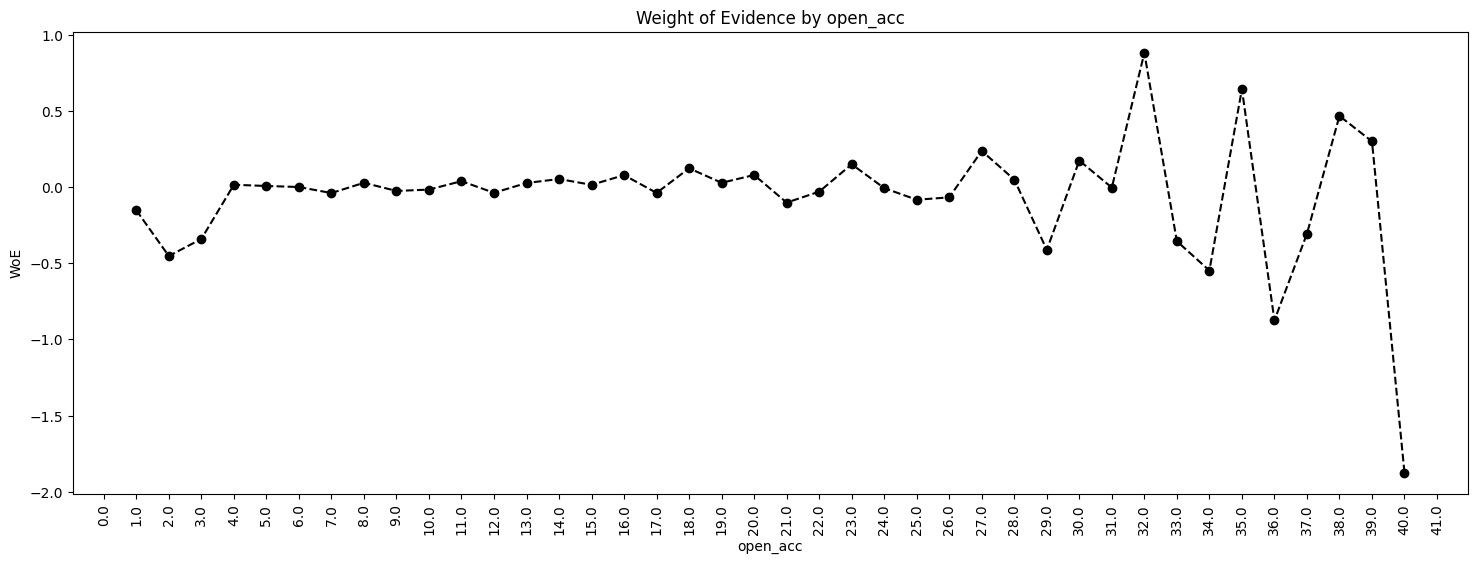

In [91]:
df_temp = calculate_woe_iv(df_inputs_prepr['open_acc'], df_targets_prepr)
plot_woe(df_temp.sort_values('open_acc', ascending = True).reset_index(drop = True),'open_acc')

## 14

In [92]:
# Categories_ '0', '1-3', '4-12', '13-17', '18-22', '23-25', '26-30', '>30'
df_inputs_prepr['open_acc_0'] = np.where((df_inputs_prepr['open_acc'] == 0), 1, 0)
df_inputs_prepr['open_acc_1-3'] = np.where((df_inputs_prepr['open_acc'] >= 1) & (df_inputs_prepr['open_acc'] <= 3), 1, 0)
df_inputs_prepr['open_acc_4-12'] = np.where((df_inputs_prepr['open_acc'] >= 4) & (df_inputs_prepr['open_acc'] <= 12), 1, 0)
df_inputs_prepr['open_acc_13-17'] = np.where((df_inputs_prepr['open_acc'] >= 13) & (df_inputs_prepr['open_acc'] <= 17), 1, 0)
df_inputs_prepr['open_acc_18-22'] = np.where((df_inputs_prepr['open_acc'] >= 18) & (df_inputs_prepr['open_acc'] <= 22), 1, 0)
df_inputs_prepr['open_acc_23-25'] = np.where((df_inputs_prepr['open_acc'] >= 23) & (df_inputs_prepr['open_acc'] <= 25), 1, 0)
df_inputs_prepr['open_acc_26-30'] = np.where((df_inputs_prepr['open_acc'] >= 26) & (df_inputs_prepr['open_acc'] <= 30), 1, 0)
df_inputs_prepr['open_acc_>=31'] = np.where((df_inputs_prepr['open_acc'] >= 31), 1, 0)

In [93]:
df_inputs_prepr['pub_rec'].unique()

array([ 0.,  1.,  2.,  4.,  3.,  5., 12., 49.,  7.,  6.,  8., 14., 11.,
       10.,  9.])

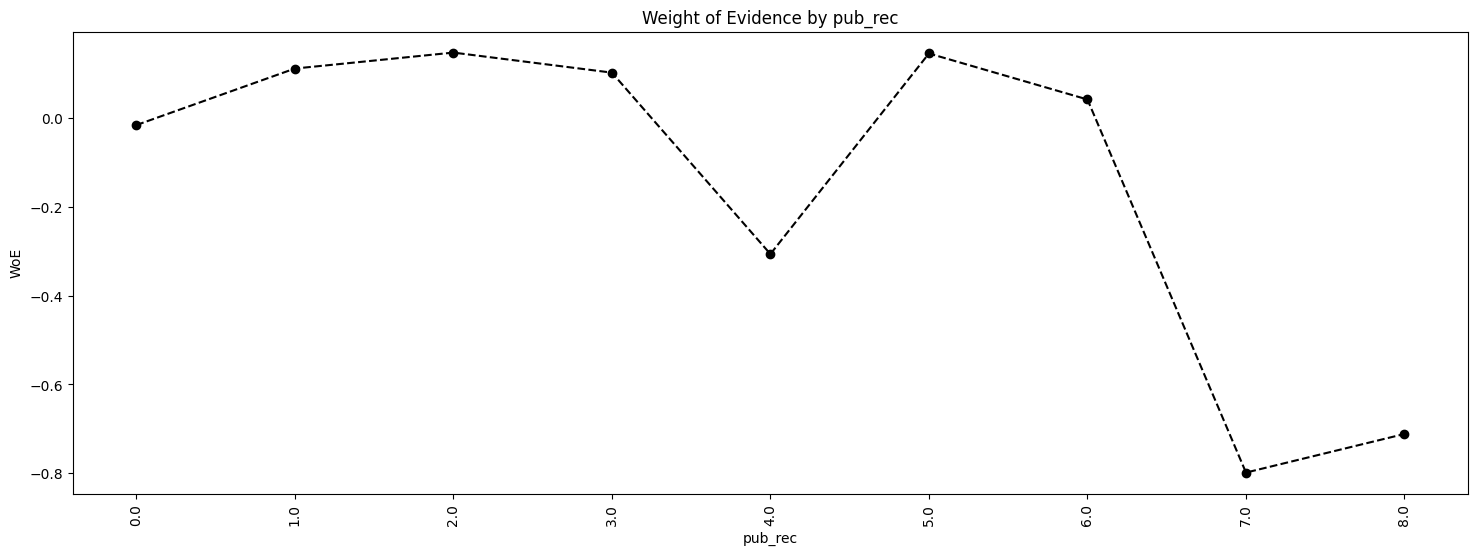

In [94]:
df_temp = calculate_woe_iv(df_inputs_prepr['pub_rec'], df_targets_prepr)
plot_woe(df_temp.sort_values('pub_rec', ascending = True).reset_index(drop = True),'pub_rec')

## 15

In [95]:
df_inputs_prepr['pub_rec_0-2'] = np.where((df_inputs_prepr['pub_rec'] >= 0) & (df_inputs_prepr['pub_rec'] <= 2), 1, 0)
df_inputs_prepr['pub_rec_3-4'] = np.where((df_inputs_prepr['pub_rec'] >= 3) & (df_inputs_prepr['pub_rec'] <= 4), 1, 0)
df_inputs_prepr['pub_rec_>=5'] = np.where((df_inputs_prepr['pub_rec'] >= 5), 1, 0)

In [96]:
df_inputs_prepr['total_acc'].unique()

array([ 20.,  43.,  38.,  31.,  36.,  48.,  10.,  45.,   5.,  32.,  26.,
        41.,  40.,  47.,   8.,  14.,  42.,  24.,   6.,  23.,  17.,  11.,
        25.,  21.,  28.,  29.,  12.,  37.,  19.,  35.,  34.,  30.,  18.,
        13.,   9.,  44.,  50.,  22.,  33.,  59.,  16.,  15.,  27.,  39.,
        46.,  63.,   7.,  52.,  56.,  54.,  49.,   4.,  57.,  60.,  53.,
        67.,  51.,  55.,  65.,  61., 156.,   3.,  66.,  58.,  80.,  64.,
        62.,  73.,  71.,  72.,  91.,  79.,  69.,   2.,  78.,   0.,  81.,
        92.,  74.,  70.,  77.,  75.,  68.,  76.,  85.,  88.,  94.,  97.,
         1.,  99.,  86.,  89.,  84.,  83.,  82.,  93.])

In [97]:
df_inputs_prepr['total_acc_factor'] = pd.cut(df_inputs_prepr['total_acc'],50)

/var/folders/nz/9brs25k93qd9j8rw4y155hp00000gn/T/ipykernel_51791/421776125.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prop_series = df.groupby([cat_series.name,outcome_series.name])[outcome_series.name].count()


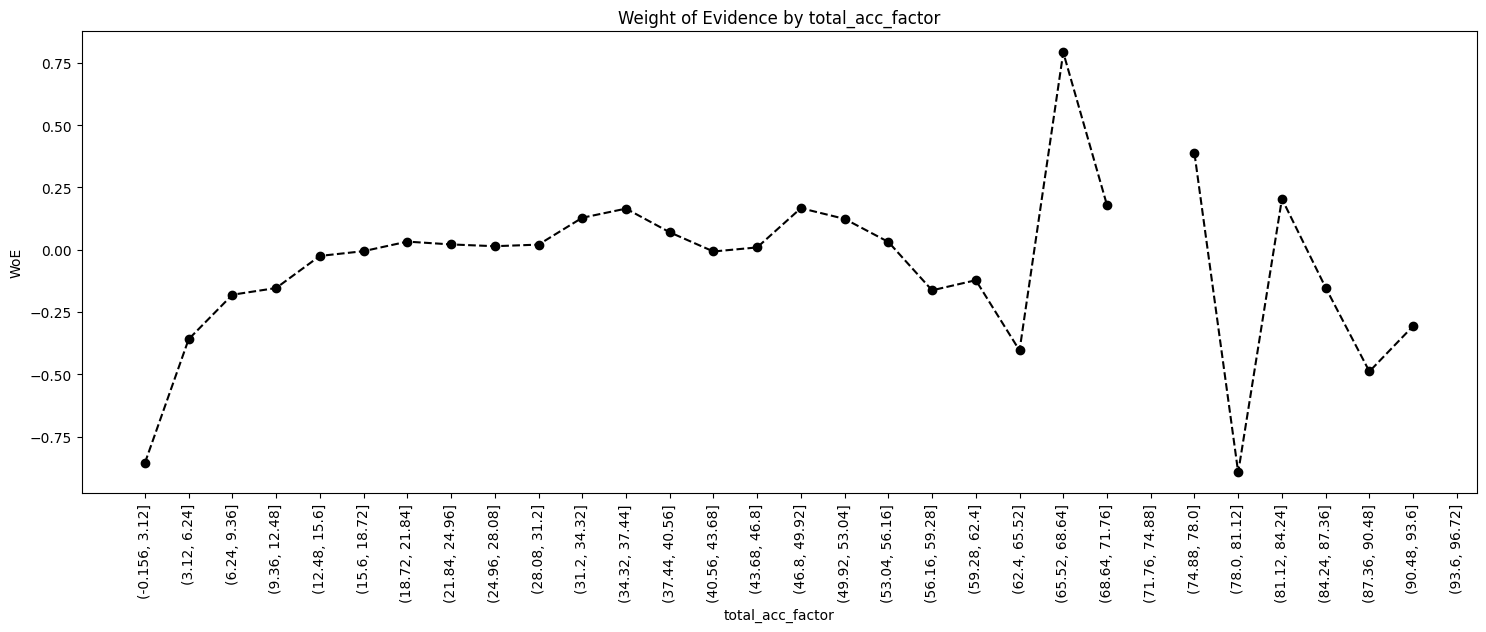

In [98]:
df_temp = calculate_woe_iv(df_inputs_prepr['total_acc_factor'], df_targets_prepr)
plot_woe(df_temp.sort_values('total_acc_factor', ascending = True).reset_index(drop = True),'total_acc_factor')

## 16

In [99]:
df_inputs_prepr['total_acc_<=27'] = np.where((df_inputs_prepr['total_acc'] <= 27), 1, 0)
df_inputs_prepr['total_acc_28-51'] = np.where((df_inputs_prepr['total_acc'] >= 28) & (df_inputs_prepr['total_acc'] <= 51), 1, 0)
df_inputs_prepr['total_acc_>=52'] = np.where((df_inputs_prepr['total_acc'] >= 52), 1, 0)

In [100]:
df_inputs_prepr['acc_now_delinq'].unique()

array([0., 1., 2., 3.])

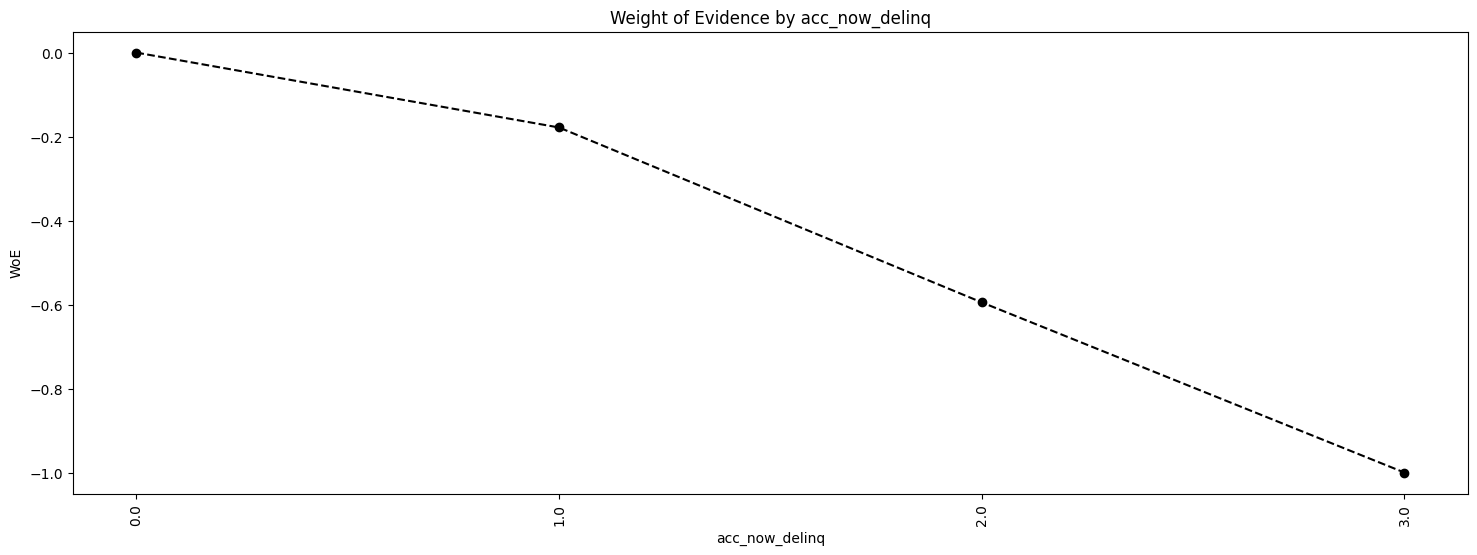

In [101]:
df_temp = calculate_woe_iv(df_inputs_prepr['acc_now_delinq'], df_targets_prepr)
plot_woe(df_temp.sort_values('acc_now_delinq', ascending = True).reset_index(drop = True),'acc_now_delinq')

## 17

In [102]:
# Categories: '0', '>=1'
df_inputs_prepr['acc_now_delinq_0'] = np.where((df_inputs_prepr['acc_now_delinq'] == 0), 1, 0)
df_inputs_prepr['acc_now_delinq_>=1'] = np.where((df_inputs_prepr['acc_now_delinq'] >= 1), 1, 0)

In [103]:
df_inputs_prepr['dti'].unique()

array([ 9.32, 24.19, 13.34, ..., 37.86, 36.4 , 36.91], shape=(3864,))

In [104]:
df_inputs_prepr['dti_factor'] = pd.cut(df_inputs_prepr['dti'],50)

/var/folders/nz/9brs25k93qd9j8rw4y155hp00000gn/T/ipykernel_51791/421776125.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prop_series = df.groupby([cat_series.name,outcome_series.name])[outcome_series.name].count()


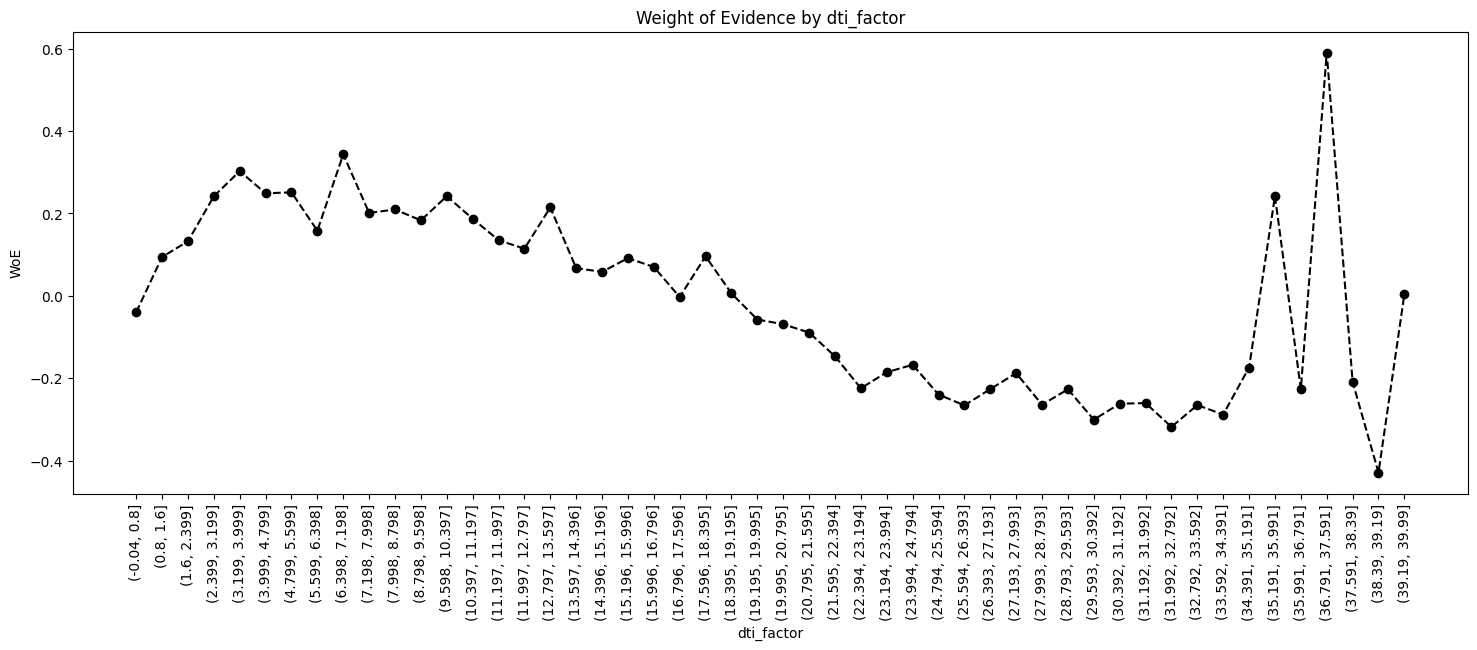

In [105]:
df_temp = calculate_woe_iv(df_inputs_prepr['dti_factor'], df_targets_prepr)
plot_woe(df_temp.sort_values('dti_factor', ascending = True).reset_index(drop = True),'dti_factor')

## 18

In [106]:
df_inputs_prepr['dti_<=1.4'] = np.where((df_inputs_prepr['dti'] <= 1.4), 1, 0)
df_inputs_prepr['dti_1.4-3.5'] = np.where((df_inputs_prepr['dti'] > 1.4) & (df_inputs_prepr['dti'] <= 3.5), 1, 0)
df_inputs_prepr['dti_3.5-7.7'] = np.where((df_inputs_prepr['dti'] > 3.5) & (df_inputs_prepr['dti'] <= 7.7), 1, 0)
df_inputs_prepr['dti_7.7-10.5'] = np.where((df_inputs_prepr['dti'] > 7.7) & (df_inputs_prepr['dti'] <= 10.5), 1, 0)
df_inputs_prepr['dti_10.5-16.1'] = np.where((df_inputs_prepr['dti'] > 10.5) & (df_inputs_prepr['dti'] <= 16.1), 1, 0)
df_inputs_prepr['dti_16.1-20.3'] = np.where((df_inputs_prepr['dti'] > 16.1) & (df_inputs_prepr['dti'] <= 20.3), 1, 0)
df_inputs_prepr['dti_20.3-21.7'] = np.where((df_inputs_prepr['dti'] > 20.3) & (df_inputs_prepr['dti'] <= 21.7), 1, 0)
df_inputs_prepr['dti_21.7-22.4'] = np.where((df_inputs_prepr['dti'] > 21.7) & (df_inputs_prepr['dti'] <= 22.4), 1, 0)
df_inputs_prepr['dti_22.4-35'] = np.where((df_inputs_prepr['dti'] > 22.4) & (df_inputs_prepr['dti'] <= 35), 1, 0)
df_inputs_prepr['dti_>35'] = np.where((df_inputs_prepr['dti'] > 35), 1, 0)

In [107]:
df_inputs_prepr['mths_since_last_record'].unique()

array([ nan, 106., 110., 115.,   0.,  70.,  75.,  64.,  58., 105.,  85.,
       108.,  20.,  71.,  41.,  66.,  80.,  97.,  33.,  59.,  27., 113.,
        95.,  94.,  40.,  74., 117.,  99.,  23.,  81.,  51.,  67.,  82.,
       107.,  68.,  55., 103., 116.,  46.,  77.,  56.,  45.,   7., 109.,
        57.,  61.,  60.,  88.,  39.,  69., 100.,  24.,  54.,  86.,  42.,
        53., 114.,  48., 111.,  50., 104.,  76., 118.,   1.,  65.,  98.,
         8.,  44., 112.,  29.,  43.,  72.,  90.,  49.,  78.,  63.,  25.,
        73.,  30.,  52.,  89.,  37., 102.,  31.,  28., 119.,  87.,  34.,
        79.,  17.,  18.,  83.,  38., 101.,  14.,  84.,  32.,  91.,  93.,
        62.,  47.,  36.,  21.,  22.,  35.,  96.,  13.,  26.,   5.,  92.,
         9.,  11.,   4.,  15.,  16.,  12.,  10.,  19.,   3.,   6., 129.,
       120.,   2.])

## 19

In [108]:
df_inputs_prepr['mths_since_last_record_Missing'] = np.where((df_inputs_prepr['mths_since_last_record'].isnull()), 1, 0)
df_inputs_prepr['mths_since_last_record_0-2'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 0) & (df_inputs_prepr['mths_since_last_record'] <= 2), 1, 0)
df_inputs_prepr['mths_since_last_record_3-20'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 3) & (df_inputs_prepr['mths_since_last_record'] <= 20), 1, 0)
df_inputs_prepr['mths_since_last_record_21-31'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 21) & (df_inputs_prepr['mths_since_last_record'] <= 31), 1, 0)
df_inputs_prepr['mths_since_last_record_32-80'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 32) & (df_inputs_prepr['mths_since_last_record'] <= 80), 1, 0)
df_inputs_prepr['mths_since_last_record_81-86'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 81) & (df_inputs_prepr['mths_since_last_record'] <= 86), 1, 0)
df_inputs_prepr['mths_since_last_record_>=86'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 86), 1, 0)

In [109]:
df_inputs_prepr['annual_inc'].unique()

array([ 65000.,  60000., 175000., ...,  81961.,  29310.,  47939.],
      shape=(9043,))

In [110]:
df_inputs_prepr['annual_inc_factor'] = pd.cut(df_inputs_prepr['annual_inc'],100)

/var/folders/nz/9brs25k93qd9j8rw4y155hp00000gn/T/ipykernel_51791/421776125.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prop_series = df.groupby([cat_series.name,outcome_series.name])[outcome_series.name].count()


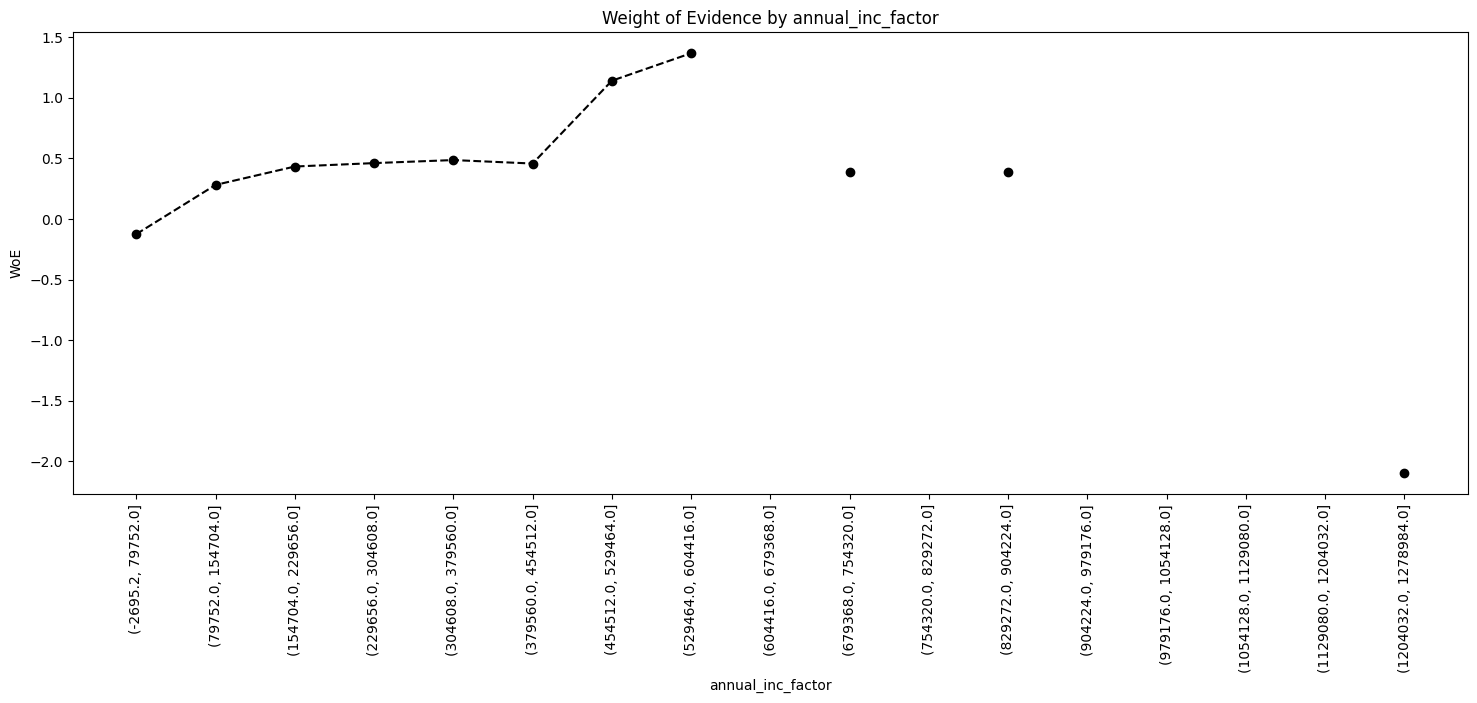

In [111]:
df_temp = calculate_woe_iv(df_inputs_prepr['annual_inc_factor'], df_targets_prepr)
plot_woe(df_temp.sort_values('annual_inc_factor', ascending = True).reset_index(drop = True),'annual_inc_factor')

In [112]:
df_temp.sort_values('annual_inc_factor', ascending = True).reset_index(drop = True).head(5)

good_bad,annual_inc_factor,prop_0,prop_1,count_0,count_1,WoE_i,IV_i,IV
0,"(-2695.2, 79752.0]",0.750147,0.661839,7644,54977,-0.125247,0.011060,inf
1,"(79752.0, 154704.0]",0.221197,0.292872,2254,24328,0.280681,0.020118,inf
2,"(154704.0, 229656.0]",0.021099,0.032516,215,2701,0.432499,0.004938,inf
3,"(229656.0, 304608.0]",0.005005,0.007933,51,659,0.460657,0.001349,inf
4,"(304608.0, 379560.0]",0.001178,0.001914,12,159,0.485757,0.000358,inf


# Split annual income into high and less and try to solve them separately

/var/folders/nz/9brs25k93qd9j8rw4y155hp00000gn/T/ipykernel_51791/1021295285.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp['annual_inc_factor'] = pd.cut(df_inputs_prepr_temp['annual_inc'],50)
/var/folders/nz/9brs25k93qd9j8rw4y155hp00000gn/T/ipykernel_51791/421776125.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prop_series = df.groupby([cat_series.name,outcome_series.name])[outcome_series.name].count()


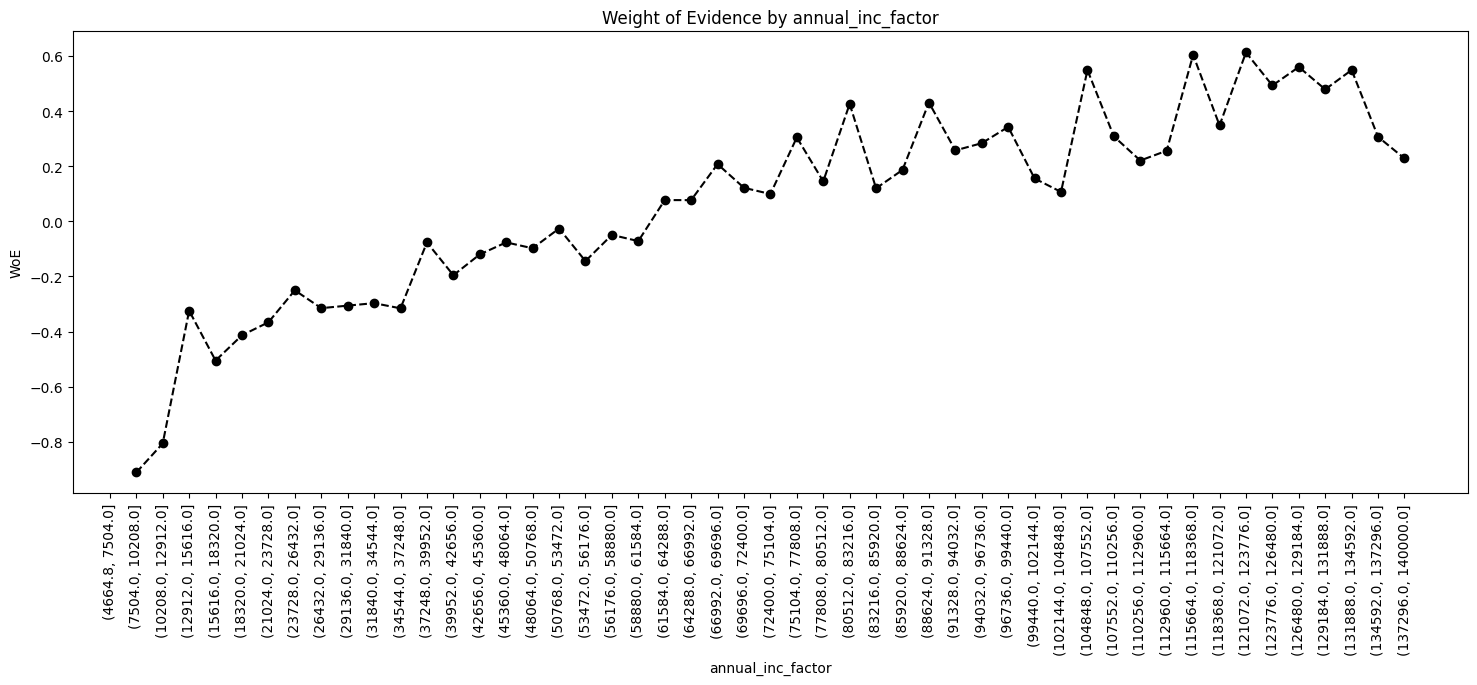

In [113]:
df_inputs_prepr_temp =  df_inputs_prepr.loc[df_inputs_prepr['annual_inc'] <= 140_000]
df_inputs_prepr_temp['annual_inc_factor'] = pd.cut(df_inputs_prepr_temp['annual_inc'],50)

df_temp = calculate_woe_iv(df_inputs_prepr_temp['annual_inc_factor'], df_targets_prepr.loc[df_inputs_prepr_temp.index])
plot_woe(df_temp.sort_values('annual_inc_factor', ascending = True).reset_index(drop = True),'annual_inc_factor')

## 20

In [114]:
# WoE is monotonically decreasing with income, so we split income in 10 equal categories, each with width of 15k.
df_inputs_prepr['annual_inc_<20K'] = np.where((df_inputs_prepr['annual_inc'] <= 20000), 1, 0)
df_inputs_prepr['annual_inc_20K-30K'] = np.where((df_inputs_prepr['annual_inc'] > 20000) & (df_inputs_prepr['annual_inc'] <= 30000), 1, 0)
df_inputs_prepr['annual_inc_30K-40K'] = np.where((df_inputs_prepr['annual_inc'] > 30000) & (df_inputs_prepr['annual_inc'] <= 40000), 1, 0)
df_inputs_prepr['annual_inc_40K-50K'] = np.where((df_inputs_prepr['annual_inc'] > 40000) & (df_inputs_prepr['annual_inc'] <= 50000), 1, 0)
df_inputs_prepr['annual_inc_50K-60K'] = np.where((df_inputs_prepr['annual_inc'] > 50000) & (df_inputs_prepr['annual_inc'] <= 60000), 1, 0)
df_inputs_prepr['annual_inc_60K-70K'] = np.where((df_inputs_prepr['annual_inc'] > 60000) & (df_inputs_prepr['annual_inc'] <= 70000), 1, 0)
df_inputs_prepr['annual_inc_70K-80K'] = np.where((df_inputs_prepr['annual_inc'] > 70000) & (df_inputs_prepr['annual_inc'] <= 80000), 1, 0)
df_inputs_prepr['annual_inc_80K-90K'] = np.where((df_inputs_prepr['annual_inc'] > 80000) & (df_inputs_prepr['annual_inc'] <= 90000), 1, 0)
df_inputs_prepr['annual_inc_90K-100K'] = np.where((df_inputs_prepr['annual_inc'] > 90000) & (df_inputs_prepr['annual_inc'] <= 100000), 1, 0)
df_inputs_prepr['annual_inc_100K-120K'] = np.where((df_inputs_prepr['annual_inc'] > 100000) & (df_inputs_prepr['annual_inc'] <= 120000), 1, 0)
df_inputs_prepr['annual_inc_120K-140K'] = np.where((df_inputs_prepr['annual_inc'] > 120000) & (df_inputs_prepr['annual_inc'] <= 140000), 1, 0)
df_inputs_prepr['annual_inc_>140K'] = np.where((df_inputs_prepr['annual_inc'] > 140000), 1, 0)

In [115]:
# mths_since_last_delinq
# We have to create one category for missing values and do fine and coarse classing for the rest.
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['mths_since_last_delinq'])]
df_inputs_prepr_temp['mths_since_last_delinq_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_delinq'], 50)


/var/folders/nz/9brs25k93qd9j8rw4y155hp00000gn/T/ipykernel_51791/3559567464.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp['mths_since_last_delinq_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_delinq'], 50)


/var/folders/nz/9brs25k93qd9j8rw4y155hp00000gn/T/ipykernel_51791/421776125.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prop_series = df.groupby([cat_series.name,outcome_series.name])[outcome_series.name].count()


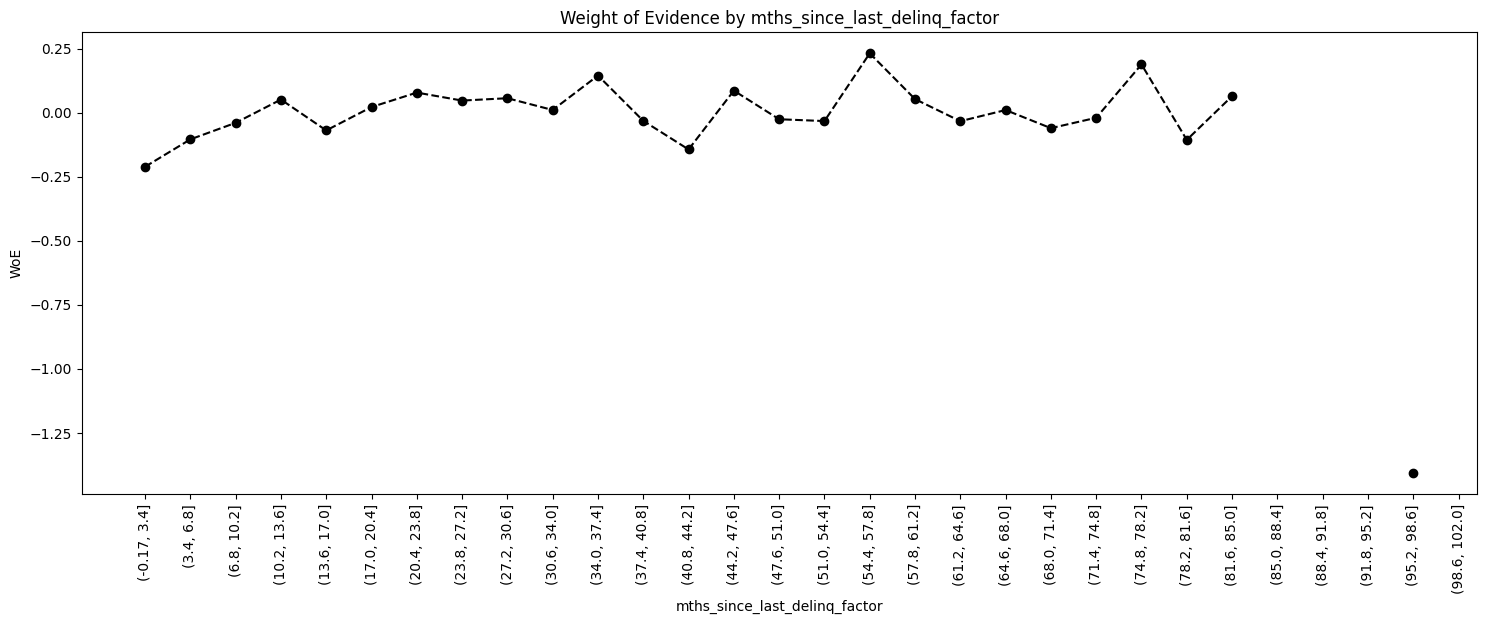

In [116]:
df_temp = calculate_woe_iv(df_inputs_prepr_temp['mths_since_last_delinq_factor'], df_targets_prepr.loc[df_inputs_prepr_temp.index])
plot_woe(df_temp.sort_values('mths_since_last_delinq_factor', ascending = True).reset_index(drop = True),'mths_since_last_delinq_factor')

## 21

In [117]:
# Categories_ Missing, 0-3, 4-30, 31-56, >=57
df_inputs_prepr['mths_since_last_delinq_Missing'] = np.where((df_inputs_prepr['mths_since_last_delinq'].isnull()), 1, 0)
df_inputs_prepr['mths_since_last_delinq_0-3'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 0) & (df_inputs_prepr['mths_since_last_delinq'] <= 3), 1, 0)
df_inputs_prepr['mths_since_last_delinq_4-30'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 4) & (df_inputs_prepr['mths_since_last_delinq'] <= 30), 1, 0)
df_inputs_prepr['mths_since_last_delinq_31-56'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 31) & (df_inputs_prepr['mths_since_last_delinq'] <= 56), 1, 0)
df_inputs_prepr['mths_since_last_delinq_>=57'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 57), 1, 0)

df_inputs_prepr['acc_now_delinq_0'] = np.where((df_inputs_prepr['acc_now_delinq'] == 0), 1, 0)
df_inputs_prepr['acc_now_delinq_>=1'] = np.where((df_inputs_prepr['acc_now_delinq'] >= 1), 1, 0)

df_inputs_prepr['total_rev_hi_lim_<=5K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] <= 5000), 1, 0)
df_inputs_prepr['total_rev_hi_lim_5K-10K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 5000) & (df_inputs_prepr['total_rev_hi_lim'] <= 10000), 1, 0)
df_inputs_prepr['total_rev_hi_lim_10K-20K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 10000) & (df_inputs_prepr['total_rev_hi_lim'] <= 20000), 1, 0)
df_inputs_prepr['total_rev_hi_lim_20K-30K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 20000) & (df_inputs_prepr['total_rev_hi_lim'] <= 30000), 1, 0)
df_inputs_prepr['total_rev_hi_lim_30K-40K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 30000) & (df_inputs_prepr['total_rev_hi_lim'] <= 40000), 1, 0)
df_inputs_prepr['total_rev_hi_lim_40K-55K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 40000) & (df_inputs_prepr['total_rev_hi_lim'] <= 55000), 1, 0)
df_inputs_prepr['total_rev_hi_lim_55K-95K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 55000) & (df_inputs_prepr['total_rev_hi_lim'] <= 95000), 1, 0)
df_inputs_prepr['total_rev_hi_lim_>95K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 95000), 1, 0)

/var/folders/nz/9brs25k93qd9j8rw4y155hp00000gn/T/ipykernel_51791/1368012734.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_inputs_prepr['mths_since_last_delinq_Missing'] = np.where((df_inputs_prepr['mths_since_last_delinq'].isnull()), 1, 0)
/var/folders/nz/9brs25k93qd9j8rw4y155hp00000gn/T/ipykernel_51791/1368012734.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_inputs_prepr['mths_since_last_delinq_0-3'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 0) & (df_inputs_prepr['mths_since_last_delinq'] <= 3),

In [118]:
df_inputs_prepr.shape

(93257, 321)

In [119]:
# loan_data_inputs_train = df_inputs_prepr.copy()

In [120]:
loan_data_inputs_test = df_inputs_prepr.copy()

In [121]:
# loan_data_inputs_train.to_csv('loan_data_inputs_train.csv', )
# loan_data_targets_train.to_csv('loan_data_targets_train.csv', )

In [122]:
loan_data_inputs_test.to_csv('loan_data_inputs_test.csv', )
loan_data_targets_test.to_csv('loan_data_targets_test.csv',)